In [1]:
import uproot as up
import awkward as ak
import pandas as pd
from scipy.optimize import curve_fit

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm, trange
from pathlib import Path

import mplhep as hep
hep.style.use('ROOT')


In [2]:
## Cut on in time nhit per event!!!

In [3]:
class Event:
    def __init__(self, 
                 timestamp, time_since_last_trigger, 
                 digit_peak, digit_neg_peak,
                 hit_ids, hit_charges, hit_times, hit_peak, 
                 xfit, yfit, zfit):
                 #waveforms):

        # Event timing data 
        self.timestamp = timestamp 
        self.time_since_last_trigger = time_since_last_trigger
        self.time_since_last_prompt_trigger = {
            'cleaned': None,
            'raw': None,
        } 

        # Event trigger data
        self.trigger_type = {
            'cleaned': 2,
            'raw': 2,
        } 

        # # Channel data 
        # self.waveforms = waveforms
        self.digit_peak = digit_peak
        self.digit_neg_peak = digit_neg_peak

        self.hit_ids = hit_ids
        self.hit_charges = hit_charges
        self.hit_times = hit_times
        self.hit_peak = hit_peak

        self.channel_mask = []

        # Quadfitter data
        self.xfit = xfit
        self.yfit = yfit
        self.zfit = zfit
 
    def make_channel_mask(self,is_sim,ratio_threshold=2):
        ids = self.hit_ids
        mask = np.zeros(len(ids),dtype=int)
        # Get the channel that was hit
        for i, id in enumerate(ids):
            # Check that the charge is positive
            if self.hit_charges[i]>0:
                # Check ratio that is roughly equivalent to the signal to noise ratio of the waveform
                # wf = []
                # if is_sim:
                #     wf = self.waveforms[i]
                # else:
                #     wf = self.waveforms[id]
                ratio = self.digit_peak[i] / (self.digit_neg_peak[i] + 1e-6)
                # ratio = (np.median(wf)-np.min(wf))/(np.max(wf)-np.median(wf) + 1e-6) 
                if ratio>=ratio_threshold:
                    mask[i]=1
        self.channel_mask = mask 
            
class Run:
    def __init__(self,number):
        # Run data
        self.number = number 
        self.files = [] 

        # Event meta data
        self.pmt_type = None
        self.pmt_id = None
        self.pmt_ch = None
        self.pmt_is_online = None # channel bitmask 
        self.pmt_cable_offset = None

        # Event output and waveform data 
        self.events = []
 
    def get_files(self, path, first=False, is_sim=False):
        path = Path(path)
        self.files.append(path)

    # Just need to open the first file
    def load_meta_data(self):
        f=up.open(self.files[0])

        print(f"Meta Keys: {f['meta'].keys()}")
        print(f"Output Keys: {f['output'].keys()}")
        #print(f"Waveform Keys: {f['waveforms'].keys()}")

        self.pmt_type = f['meta']['pmtType'].array(library='np')[0]
        self.pmt_id = f['meta']['pmtId'].array(library='np')[0]
        self.pmt_ch = f['meta']['pmtChannel'].array(library='np')[0]
        self.pmt_is_online = f['meta']['pmtIsOnline'].array(library='np')[0]
        self.pmt_cable_offset = f['meta']['pmtCableOffset'].array(library='np')[0]

        print("Meta Data Loaded!")

    # Open all the files
    def load_event_data(self,n,is_sim=False):
        for file in tqdm(self.files, desc=f"Parsing event data for {len(self.files)} files for run {self.number}", colour='green'):
            f=up.open(file)
            print(f"File: {file}")

            # Trigger timing 
            timestamp = f['output']['timestamp'].array(entry_stop=n, library='ak')
            time_since_last_trigger = f['output']['timeSinceLastTrigger_us'].array(entry_stop=n, library='ak')

            # Digit Peaks
            digit_peak = f['output']['digitPeak'].array(entry_stop=n, library='ak')
            digit_neg_peak = f['output']['digitNegativePeak'].array(entry_stop=n,library='ak')

            # Hit data
            hit_ids = f['output']['digitPMTID'].array(entry_stop=n,library='ak')
            hit_charges = f['output']['digitCharge'].array(entry_stop=n,library='ak')
            hit_times = f['output']['digitTime'].array(entry_stop=n,library='ak')
            hit_peak = f['output']['digitPeak'].array(entry_stop=n,library='ak')

            # hit_ids = f['output']['digitPMTID'].array(library='ak')
            # hit_charges = f['output']['digitCharge'].array(library='ak')
            # hit_times = f['output']['digitTime'].array(library='ak')

            # Event vertex reconstruction
            xfit = f['output']['x_quadfitter'].array(entry_stop=n,library='ak')
            yfit = f['output']['y_quadfitter'].array(entry_stop=n,library='ak')
            zfit = f['output']['z_quadfitter'].array(entry_stop=n,library='ak')

            # # Channel waveforms 
            # waveforms = f['waveforms']['waveform'].array(library='np')
            # waveform_id = f['waveforms']['waveform_pmtid'].array(library='np')

            # # Remove all waveforms with negative pmt ids 
            # # They are the channel 15s used to trigger the CAENs
            # waveforms = waveforms[waveform_id>=0]

            # reshaped_waveforms = []
            # start_idx = 0
            # for i in range(len(hit_ids)):
            #     num_hits = len(hit_ids[i])
            #     if not is_sim:
            #         num_hits = 241 # all channels digitized for real run
            #     end_idx = start_idx + num_hits
            #     reshaped_waveforms.append(waveforms[start_idx:end_idx])
            #     start_idx = end_idx

            # Create event class instances
            for i in range(len(hit_ids)):
                event = Event(
                    timestamp[i],
                    time_since_last_trigger[i],
                    digit_peak[i],
                    digit_neg_peak[i],
                    hit_ids[i],
                    hit_charges[i],
                    hit_times[i],
                    hit_peak[i],
                    xfit[i],
                    yfit[i],
                    zfit[i],
                    # reshaped_waveforms[i],
                )
                event.make_channel_mask(is_sim) 
                self.events.append(event)
            
            print("Event data loaded!")

    # Event selection
    def reset_downstream(self):
        for event in self.events:
            event.trigger_type = {key:2 for key in event.trigger_type.keys()}
            event.time_since_last_prompt_trigger = {key:None for key in event.trigger_type.keys()} 
            
    def set_trigger_types_with_nhit(self,prompt_nhit_range, follower_nhit_range,is_sim=False,channel_is_good=None):
        for event in self.events:
            for key in event.trigger_type:
                nhit = len(event.hit_ids)
                if key=='cleaned':
                    nhit = len(event.hit_ids[event.channel_mask==1])
                    if is_sim:
                        cleaned_ids = event.hit_ids[event.channel_mask==1]
                        good_ids = []
                        for id in cleaned_ids:
                            if id in channel_is_good:
                                good_ids.append(id) 
                        nhit = len(good_ids)
                if prompt_nhit_range[0] <= nhit < prompt_nhit_range[1]:
                    event.trigger_type[key] = 0 
                elif follower_nhit_range[0] <= nhit < follower_nhit_range[1]:
                    event.trigger_type[key] = 1 
    
    def set_time_since_last_prompt_trigger(self):
        for key in self.events[0].trigger_type:
            last_prompt_time = self.events[0].timestamp # set start time to the first event
            for event in self.events: # skip the first event 
                if event.trigger_type[key]==1: 
                    event.time_since_last_prompt_trigger[key] = (event.timestamp - last_prompt_time) / 1e3
                if event.trigger_type[key]==0:
                    last_prompt_time = event.timestamp



In [4]:
# path = '/nfs/disk1/eos/eos-processed-data-nubar/'
#path = '/nfs/disk1/users/bharris/eos/new_sim/'

path = '/nfs/disk1/eos/eos-processed-data-nubar/run3056/data-3056.root'

run = Run(3056)
run.get_files(path,is_sim=False,first=False)
run.load_meta_data()
run.load_event_data(n=10000,is_sim=False)



Meta Keys: ['runId', 'runType', 'runTime', 'dsentries', 'macro', 'pmtType', 'pmtId', 'pmtChannel', 'pmtIsOnline', 'pmtCableOffset', 'pmtChargeScale', 'pmtPulseWidthScale', 'pmtX', 'pmtY', 'pmtZ', 'pmtU', 'pmtV', 'pmtW', 'digitizerWindowSize', 'digitizerSampleRate_GHz', 'digitizerDynamicRange_mV', 'digitizerResolution_mVPerADC', 'calibId', 'calibMode', 'calibIntensity', 'calibWavelength', 'calibName', 'calibTime', 'calibX', 'calibY', 'calibZ', 'calibU', 'calibV', 'calibW', 'geo_index', 'geo_file', 'experiment', 'source_pos_x', 'source_pos_y', 'source_pos_z', 'source_rot_x', 'source_rot_y', 'source_rot_z']
Output Keys: ['mcpdg', 'mcx', 'mcy', 'mcz', 'mcu', 'mcv', 'mcw', 'mcke', 'mct', 'evid', 'subev', 'nhits', 'triggerTime', 'timestamp', 'trigger_word', 'event_cleaning_word', 'timeSinceLastTrigger_us', 'mcid', 'mcparticlecount', 'mcpecount', 'mcnhits', 'scintEdep', 'scintEdepQuenched', 'scintPhotons', 'remPhotons', 'cherPhotons', 'hitPMTID', 'hitPMTTime', 'hitPMTCharge', 'digitNhits', 'd

Parsing event data for 1 files for run 3056:   0%|          | 0/1 [00:00<?, ?it/s]

File: /nfs/disk1/eos/eos-processed-data-nubar/run3056/data-3056.root


Parsing event data for 1 files for run 3056: 100%|██████████| 1/1 [00:13<00:00, 13.84s/it]

Event data loaded!


In [5]:
print(run.events[0].hit_charges)


[4.22, 5.01, 12.7, 1.59, 3.92, 14.2, ..., 5.09, 2.23, 1.95, 2.17, 1.91, 1.47]


In [6]:
# path = '/nfs/disk1/users/bharris/eos/new_sim/'

# sim=Run(1246)
# sim.get_files(path,is_sim=True,first=True)
# sim.load_meta_data()
# sim.load_event_data(is_sim=True)



[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 32, 33, 34, 35, 38, 39, 41, 42, 45, 47, 49, 50, 51, 52, 53, 54, 55, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 71, 73, 74, 76, 77, 78, 79, 80, 81, 82, 83, 84, 86, 87, 90, 91, 92, 93, 95, 96, 97, 98, 99, 100, 101, 103, 104, 105, 107, 108, 109, 110, 112, 113, 114, 115, 116, 117, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 132, 133, 134, 135, 136, 137, 138, 139, 141, 142, 143, 145, 146, 147, 149, 150, 151, 152, 153, 154, 155, 157, 159, 161, 162, 163, 164, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 200, 201, 202, 203, 205, 206, 207, 208, 209, 210, 213, 214, 215, 216, 218, 219, 223, 224, 228, 230, 231, 235, 236, 237, 238, 240]


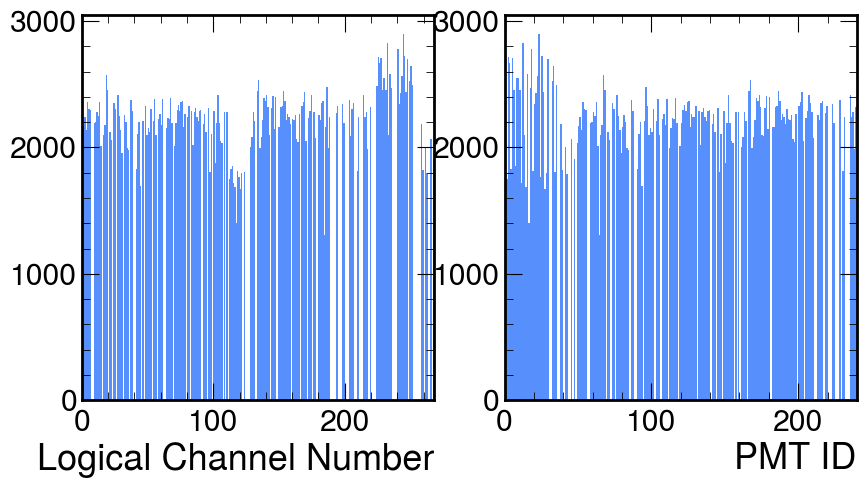

In [7]:
pmt_id_to_ch = dict(zip(run.pmt_id, run.pmt_ch))
pmt_ch_to_id = dict(zip(run.pmt_ch, run.pmt_id))

def plot_pmt_channel_hist(events):
    ids = []
    chs = []
    for event in events:
        for id in event.hit_ids[event.channel_mask==1]:
            ids.append(id)
            chs.append(pmt_id_to_ch[id])
    fig,ax=plt.subplots(1,2,figsize=(10,5))
    ax[0].hist(chs,bins=np.max(run.pmt_ch),range=(0,np.max(run.pmt_ch)))
    ax[0].set_xlim(0,np.max(run.pmt_ch))
    ax[0].set_xlabel('Logical Channel Number')
    ax[1].hist(ids,bins=np.max(run.pmt_id),range=(0,np.max(run.pmt_id)))
    ax[1].set_xlim(0,np.max(run.pmt_id))
    ax[1].set_xlabel('PMT ID')
    unique_ids = list(set(ids))
    unique_ids = [int(x) for x in unique_ids]
    unique_ids.sort()
    return unique_ids 

#cleaned_sim_good_hit_ids = plot_pmt_channel_hist(sim.events)
cleaned_run_good_hit_ids = plot_pmt_channel_hist(run.events)

print(cleaned_run_good_hit_ids)

# for i in range(len(run.pmt_is_online)):
#     if i in cleaned_run_hit_ids and run.pmt_is_online[i]:
#         print(f"Channel {i} is online and was hit")
#     elif i in cleaned_run_hit_ids and not run.pmt_is_online[i]:
#         print(f"Channel {i} is offline and was hit")
#     elif i not in cleaned_run_hit_ids and run.pmt_is_online[i]:
#         print(f"Channel {i} is online and was not hit")
#     else:
#         print(f"Channel {i} is offline and was not hit")

# List of all channels that were hit after data cleaning
# Removes offline chanels
# Removes channels that are all noise


There are only 194 channels working in the run!
Got 49.23 s of data
******************************************
raw Prompt trigger frequency 653.604 Hz
raw Follower trigger frequency 50.824 Hz
******************************************
raw Prompt triggers 2011
raw Follower triggers 2502
******************************************
cleaned Prompt trigger frequency 301.288 Hz
cleaned Follower trigger frequency 35.772 Hz
******************************************
cleaned Prompt triggers 927
cleaned Follower triggers 1761
10000 events in this run


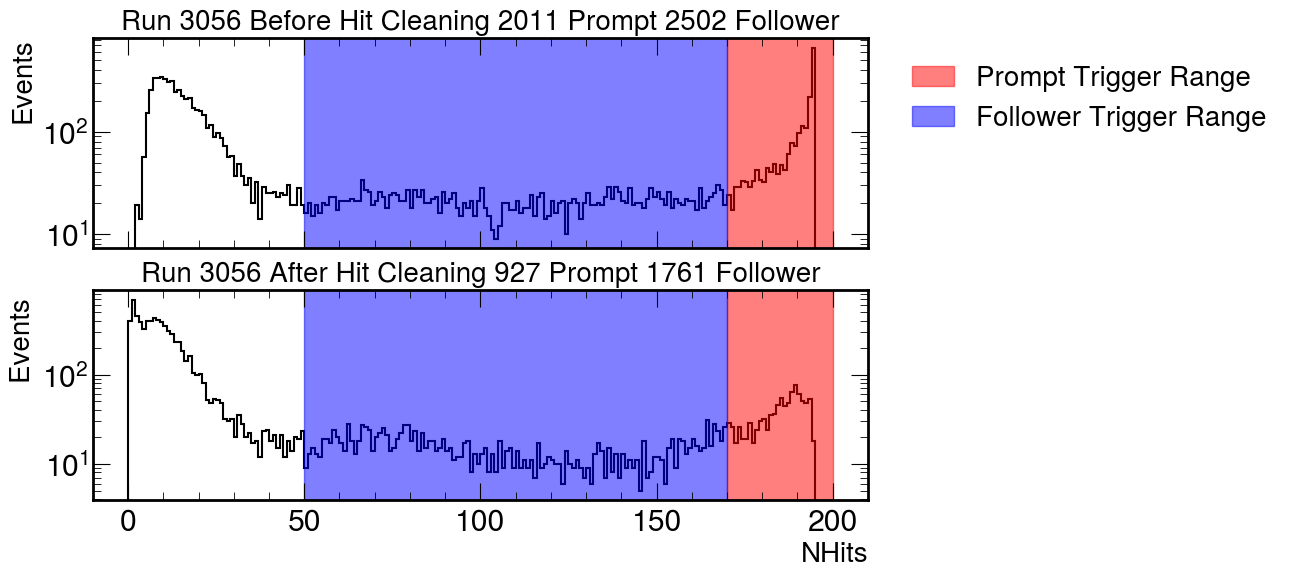

In [8]:
prompt_nhit_range = (170,200)
follower_nhit_range = (50,170)
print(f"There are only {len(cleaned_run_good_hit_ids)} channels working in the run!")

run.reset_downstream()
run.set_trigger_types_with_nhit(prompt_nhit_range, follower_nhit_range)
run.set_time_since_last_prompt_trigger()
trigger_counts = {
    "raw": {0: 0, 1: 0, 2: 0},
    "cleaned": {0: 0, 1: 0, 2: 0}
}
for event in run.events:
    for key in event.trigger_type:
        trigger_counts[key][event.trigger_type[key]] += 1
prescale = 16
ts = [event.timestamp for event in run.events]
run_time = (ts[-1]-ts[0])/1e9
print(f"Got {run_time:.2f} s of data")
for key in trigger_counts:
    print("******************************************")
    print(f"{key} Prompt trigger frequency {16*trigger_counts[key][0]/run_time:.3f} Hz")
    print(f"{key} Follower trigger frequency {trigger_counts[key][1]/run_time:.3f} Hz")
    print("******************************************")
    print(f"{key} Prompt triggers {trigger_counts[key][0]}")
    print(f"{key} Follower triggers {trigger_counts[key][1]}")
# Plot dirty and clean nhits 
nhits = [len(event.hit_ids) for event in run.events]
print(f"{len(run.events)} events in this run")
cleaned_nhits = [ak.sum(event.channel_mask) for event in run.events]

fig,ax = plt.subplots(2,1,figsize=(10, 6),sharex=True)
hep.histplot(np.histogram(nhits, bins=200, range=(0, 200)), ax=ax[0], color='black')
ax[0].axvspan(prompt_nhit_range[0], prompt_nhit_range[1], color='red', alpha=0.5, label='Prompt Trigger Range')
ax[0].axvspan(follower_nhit_range[0], follower_nhit_range[1], color='blue', alpha=0.5, label='Follower Trigger Range')
ax[0].legend(loc='upper right',bbox_to_anchor=(1.55, 1),fontsize=20)
ax[0].set_title(f"Run {run.number} Before Hit Cleaning {trigger_counts['raw'][0]} Prompt {trigger_counts['raw'][1]} Follower",fontsize=20)
ax[0].set_ylabel('Events', fontsize=20)
ax[0].set_yscale('log')
hep.histplot(np.histogram(cleaned_nhits, bins=200, range=(0, 200)), ax=ax[1], color='black')
ax[1].axvspan(prompt_nhit_range[0], prompt_nhit_range[1], color='red', alpha=0.5, label='Prompt Trigger Range')
ax[1].axvspan(follower_nhit_range[0], follower_nhit_range[1], color='blue', alpha=0.5, label='Follower Trigger Range')
ax[1].set_title(f"Run {run.number} After Hit Cleaning {trigger_counts['cleaned'][0]} Prompt {trigger_counts['cleaned'][1]} Follower",fontsize=20)
ax[1].set_xlabel('NHits', fontsize=20) 
ax[1].set_ylabel('Events ',fontsize=20)
ax[1].set_yscale('log')



In [9]:
# prompt_nhit_range = (170,200)
# follower_nhit_range = (40,170)
# print(f"There are only {len(cleaned_run_good_hit_ids)} channels working in the run!")

# sim.reset_downstream()
# sim.set_trigger_types_with_nhit(prompt_nhit_range, follower_nhit_range,is_sim=True,channel_is_good=cleaned_sim_good_hit_ids)
# sim.set_time_since_last_prompt_trigger()
# trigger_counts = {
#     "raw": {0: 0, 1: 0, 2: 0},
#     "cleaned": {0: 0, 1: 0, 2: 0}
# }
# for event in sim.events:
#     for key in event.trigger_type:
#         trigger_counts[key][event.trigger_type[key]] += 1
# prescale = 16
# ts = [event.timestamp for event in sim.events]
# run_time = (ts[-1]-ts[0])/1e9
# print(f"Got {run_time:.2f} s of data")
# for key in trigger_counts:
#     print("******************************************")
#     print(f"{key} Prompt trigger frequency {16*trigger_counts[key][0]/run_time:.3f} Hz")
#     print(f"{key} Follower trigger frequency {trigger_counts[key][1]/run_time:.3f} Hz")
#     print("******************************************")
# # Plot dirty and clean nhits 
# nhits = [len(event.hit_ids) for event in sim.events]
# print(f"{len(run.events)} events in this run")
# cleaned_nhits = []
# for event in sim.events:
#     cleaned_ids = event.hit_ids[event.channel_mask==1]
#     good_ids = []
#     for id in cleaned_ids:
#         if id in cleaned_run_good_hit_ids:
#             good_ids.append(id) 
#     cleaned_nhits.append(len(good_ids))

# fig,ax = plt.subplots(2,1,figsize=(10, 6),sharex=True)
# hep.histplot(np.histogram(nhits, bins=200, range=(0, 200)), ax=ax[0], color='black')
# ax[0].axvspan(prompt_nhit_range[0], prompt_nhit_range[1], color='red', alpha=0.5, label='Prompt Trigger Range')
# ax[0].axvspan(follower_nhit_range[0], follower_nhit_range[1], color='blue', alpha=0.5, label='Follower Trigger Range')
# ax[0].legend(loc='upper right',bbox_to_anchor=(1.55, 1),fontsize=20)
# ax[0].set_title(f"Before Data Cleaning {trigger_counts['raw'][0]} Prompt {trigger_counts['raw'][1]} Follower",fontsize=20)
# ax[0].set_ylabel('Events', fontsize=20)
# ax[0].set_yscale('log')
# hep.histplot(np.histogram(cleaned_nhits, bins=200, range=(0, 200)), ax=ax[1], color='black')
# ax[1].axvspan(prompt_nhit_range[0], prompt_nhit_range[1], color='red', alpha=0.5, label='Prompt Trigger Range')
# ax[1].axvspan(follower_nhit_range[0], follower_nhit_range[1], color='blue', alpha=0.5, label='Follower Trigger Range')
# ax[1].set_title(f"After Data Cleaning {trigger_counts['cleaned'][0]} Prompt {trigger_counts['cleaned'][1]} Follower",fontsize=20)
# ax[1].set_xlabel('NHits', fontsize=20) 
# ax[1].set_ylabel('Events ',fontsize=20)
# ax[1].set_yscale('log')



Text(0.5, 1.0, '$\\Delta$ TS since last prompt trigger')

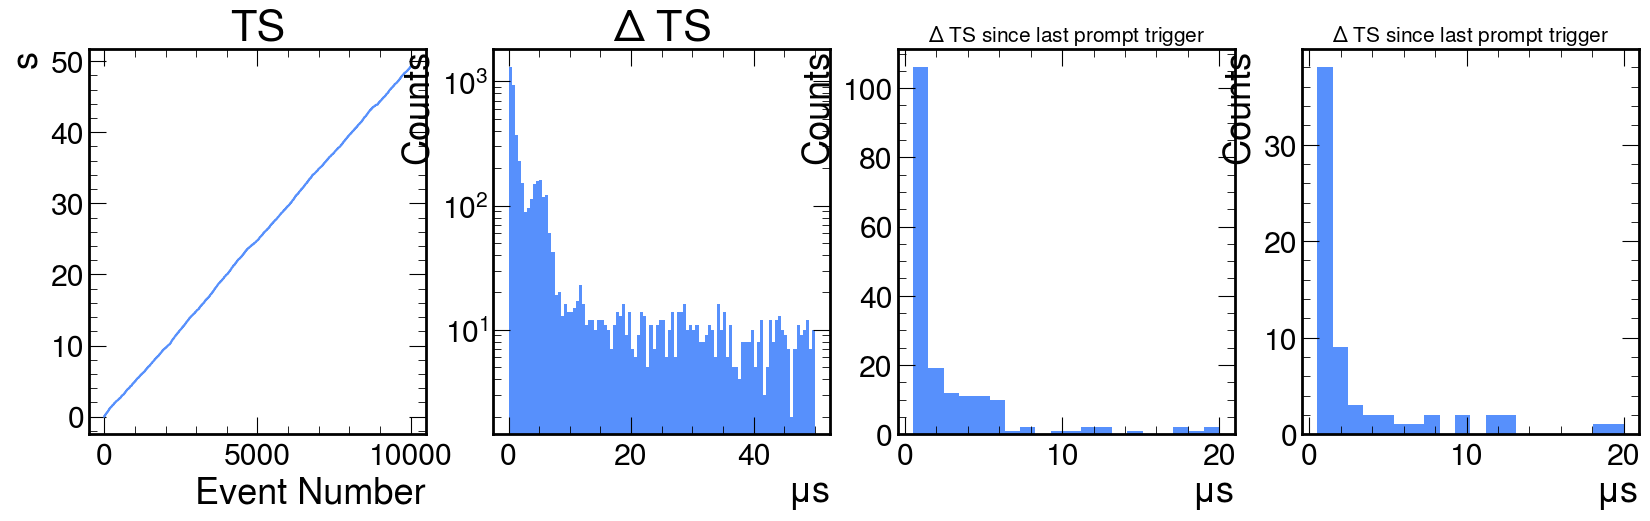

In [10]:
# Can only do this for run data

ts = [(event.timestamp-run.events[0].timestamp)/1e9 for event in run.events]
tslt = [event.time_since_last_trigger for event in run.events]
ptslpt = [event.time_since_last_prompt_trigger for event in run.events if event.trigger_type==0]
ftslpt_raw = [event.time_since_last_prompt_trigger['raw'] for event in run.events if event.trigger_type['raw']==1]
ftslpt_cleaned = [event.time_since_last_prompt_trigger['cleaned'] for event in run.events if event.trigger_type['cleaned']==1]
trigger_type_raw = [event.trigger_type['raw'] for event in run.events]

fig,ax=plt.subplots(1,4,figsize=(20,5))




ax[0].plot(ts)
ax[0].set_xlabel('Event Number')
ax[0].set_ylabel('s')
ax[0].set_title('TS')

ax[1].hist(tslt,bins=100,range=(0,50))
ax[1].set_ylabel('Counts')
ax[1].set_xlabel('$\mu$s')
ax[1].set_yscale('log')
ax[1].set_title('$\Delta$ TS')

ax[2].hist(ftslpt_raw,bins=20,range=(0.5,20))
ax[2].set_ylabel('Counts')
ax[2].set_xlabel('$\mu$s')
# ax[2].set_yscale('log')
ax[2].set_title('$\Delta$ TS since last prompt trigger',fontsize=15)

ax[3].hist(ftslpt_cleaned,bins=20,range=(0.5,20))
ax[3].set_ylabel('Counts')
ax[3].set_xlabel('$\mu$s')
# ax[3].set_yscale('log')
ax[3].set_title('$\Delta$ TS since last prompt trigger',fontsize=15)

Fit results:
A = 258.708 ± 102.210
tau = 0.679 ± 0.225
B = 2.520 ± 0.958
Chi2 = 0.251
Chi2/dof = 0.125


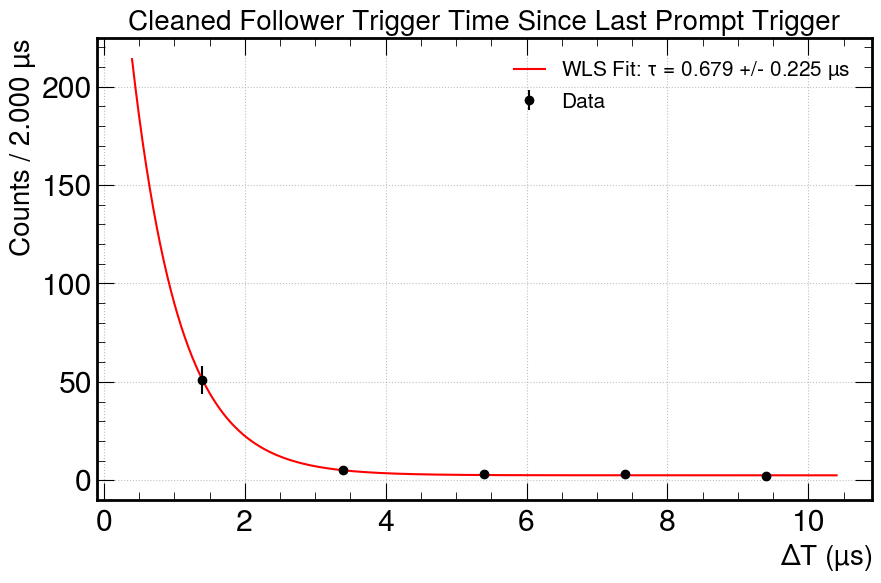

In [11]:
def fit_decay_hist(data,title,bins=5,range=(0.4,10.4),tau_guess=2):

    counts, bin_edges = np.histogram(data, bins=bins, range=range)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    sigma = np.sqrt(counts)

    def decay_model(t, A, tau, B):
        return (A / tau) * np.exp(-t / tau) + B
    
    # Initial guess for the parameters
    A_guess = np.max(counts) * (range[1] - range[0]) / bins
    B_guess = np.min(counts)
    p0 = [A_guess, tau_guess, B_guess]

    popt, pcov = curve_fit(decay_model, bin_centers, counts, sigma=sigma, absolute_sigma=True, p0=p0, maxfev=100000) 

    A_fit, tau_fit, B_fit = popt
    A_err, tau_err, B_err = np.sqrt(np.diag(pcov))

    residuals = counts - decay_model(bin_centers, *popt)
    chi2 = np.sum((residuals / sigma) ** 2)
    dof = len(counts) - len(popt)
    chi2_red = chi2 / dof

    print("Fit results:")
    print(f"A = {A_fit:.3f} ± {A_err:.3f}")
    print(f"tau = {tau_fit:.3f} ± {tau_err:.3f}")
    print(f"B = {B_fit:.3f} ± {B_err:.3f}")
    print(f"Chi2 = {chi2:.3f}")
    print(f"Chi2/dof = {chi2_red:.3f}")

    plt.figure(figsize=(10, 6))
    plt.errorbar(bin_centers, counts, yerr=sigma, fmt='o', color='black', label='Data')
    t_fine = np.linspace(*range, 1000)
    plt.plot(t_fine, decay_model(t_fine, *popt), color='red', label=fr'WLS Fit: $\tau$ = {tau_fit:.3f} +/- {tau_err:.3f} µs')
    plt.xlabel('$\Delta$T (µs)', fontsize=20)
    plt.ylabel(f"Counts / {(range[-1]-range[0])/bins:.3f} µs",fontsize=20)
    plt.title(title,fontsize=20)
    plt.grid(True)
    #plt.yscale('log')
    #plt.axvspan(0.5,3, color='blue', alpha=0.5, label='Selected Events')
    plt.legend(fontsize=15)
    plt.show()

import os

def write_to_file(filename, values):
    """Deletes and rewrites the file with the given list of values."""
    if os.path.exists(filename):
        os.remove(filename)
    with open(filename, 'w') as f:
        for value in values:
            f.write(f"{value}\n")

write_to_file('decay_times.txt',ftslpt_cleaned)

#fit_decay_hist(ftslpt_raw,"Raw Follower Trigger Time Since Last Prompt Trigger")
fit_decay_hist(ftslpt_cleaned,"Cleaned Follower Trigger Time Since Last Prompt Trigger")

#plt.hist(ftslpt_raw,bins=20,range=(0.5,20.5))


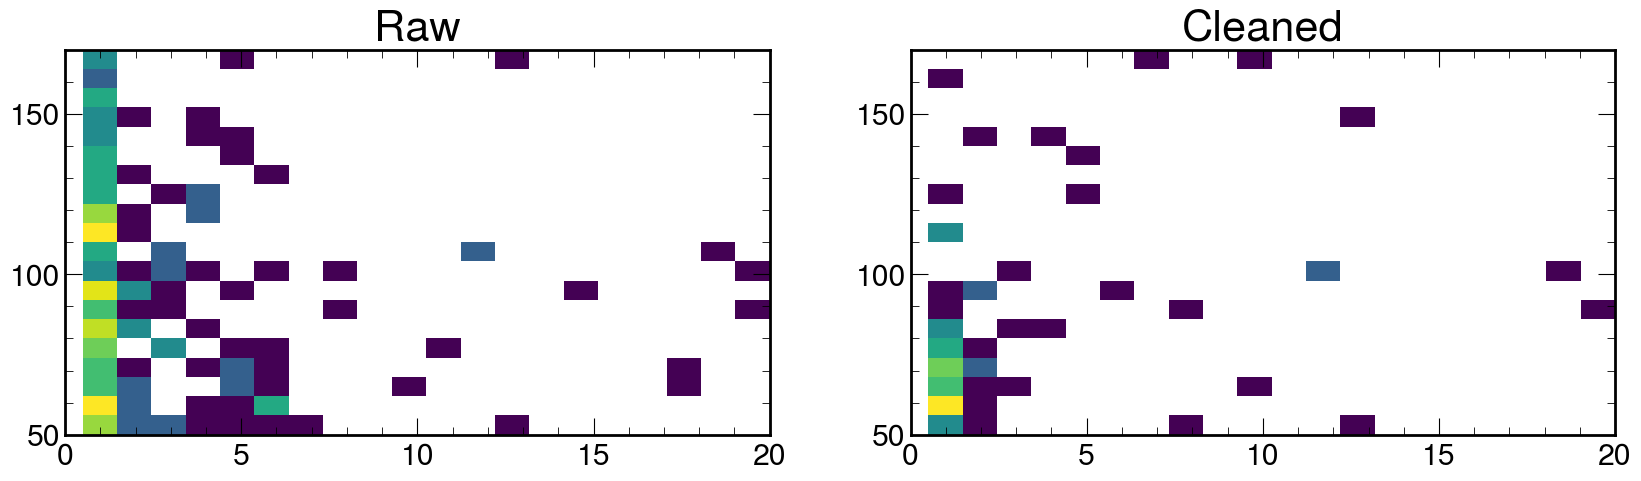

In [12]:


nhits_raw = [len(event.hit_ids) for event in run.events if event.trigger_type['raw']==1]
nhits_cleaned = [len(event.hit_ids[event.channel_mask==1]) for event in run.events if event.trigger_type['cleaned']==1]

bins=20
fig,ax=plt.subplots(1,2,figsize=(20,5))
ax[0].hist2d(ftslpt_raw,nhits_raw,bins=(bins,bins),range=((0.5,20),follower_nhit_range),norm='log')
ax[0].set_xticks(np.arange(0,21,5));
ax[0].set_yticks(np.arange(follower_nhit_range[0],follower_nhit_range[1],50))
ax[0].set_title('Raw')
ax[1].hist2d(ftslpt_cleaned,nhits_cleaned,bins=(bins,bins),range=((0.5,20),follower_nhit_range),norm='log')
ax[1].set_xticks(np.arange(0,21,5));
ax[1].set_yticks(np.arange(follower_nhit_range[0],follower_nhit_range[1],50))
ax[1].set_title('Cleaned');



In [13]:


# all = [event for event in run.events]# if event.trigger_type==1 and event.time_since_last_prompt_trigger<4 and np.sum(event.hit_charge)<500]

# rat =[]
# for event in all:
#     for i, wf in enumerate(event.waveforms):
#         if i in event.hit_ids:
#             rat.append((np.median(wf)-np.min(wf))/(np.max(wf)-np.median(wf)))


In [14]:
# digitcharge =[]
# cleaned_digitcharge =[]
# for event in all:
#     for i, hc in enumerate(event.hit_charges):
#         digitcharge.append(hc)
#     for i, hc in enumerate(event.hit_charges[event.channel_mask==1]):
#         cleaned_digitcharge.append(hc)

In [15]:
# charge_threshold=0.8
# ratio_threshold=2

# fig,ax = plt.subplots(1,2,figsize=(20,8))
# # ax[0].hist(digitCharge,bins=100,range=(-3,5),histtype='step',label='Before NegAmp/PosAmp cut')
# # ax[0].hist(cleaned_digitCharge,bins=100,range=(-3,5),histtype='step',label='After NegAmp/PosAmp cut')
# # #ax[0].axvline(charge_threshold,color='red')
# # ax[0].legend(loc='upper left',fontsize=14)
# # ax[0].set_xlabel('Hit Digit Charge (pC)')
# ax[0].hist(rat,bins=100,range=(0,10))
# #ax[0].axvline(ratio_threshold,color='red')
# ax[0].set_yscale('log')
# ax[0].set_xlabel('NegAmp/PosAmp')
# ax[1].hist2d(digitCharge,rat,bins=(100,100),range=((-5,5),(0,10)),norm='log');
# #ax[2].axvline(charge_threshold,color='red')
# #ax[2].axhline(ratio_threshold,color='red')
# ax[1].set_ylabel('NegAmp/PosAmp')
# ax[1].set_xlabel('Hit Digit Charge (pC)')
ax[1].set_title(f"Run {run.number}")


Text(0.5, 1.0, 'Run 3056')

In [16]:
# followers = [event for event in run.events if event.trigger_type==1]

run_michels = [event for event in run.events if event.trigger_type['cleaned']==1 and event.time_since_last_prompt_trigger['cleaned']<3]
#sim_michels = [event for event in sim.events]

# print(len(michels))
#bad_michels = [event for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger<4 and np.sum(event.hit_charge)<100]

bad = [event for event in run.events if np.sum(event.hit_charges)<0]
# high_charge = [event for event in run.events if np.sum(event.hit_charge[event.good_channel_mask==1])>11000]

#ringing = [event for event in run.events if event.trigger_type['cleaned']==1 and 10<ak.sum(event.channel_ratio_mask)<20 and 5.5<event.time_since_last_prompt_trigger['cleaned']<6]

In [17]:

# def plot_event_waveforms(events, event_id, columns=5,sim=False):
#     print(len(events))
#     event = events[event_id]  
#     waveforms = event.waveforms
#     charges = event.hit_charges
#     hit_ids = event.hit_ids
#     mask = event.channel_mask

#     rows = (len(hit_ids) + columns - 1) // columns  # Calculate the number of rows

#     vres=2000/pow(2,14)
#     time=np.arange(-110,110,2)
#     if sim:
#         time=np.arange(-512,512,2)
#     fontsize=10
#     print(len(time),len(waveforms[0]))

#     fig, axes = plt.subplots(rows, columns, figsize=(15, rows * 3))
#     axes = axes.flatten()  # Flatten the axes for easy indexing
#     for i, wf in enumerate(waveforms):
#         charge_value=None
#         if i in hit_ids:
#             charge_index = ak.where(hit_ids==i)
#             charge_value = charges[charge_index]
#             val = (np.median(wf)-np.min(wf))/(np.max(wf)-np.median(wf))
#             title = f"PMT ID: {i} \n Digit Charge: {charge_value[0]:.2f} pC \n NegAmp/PosAmp: {val:.2f}"
#             j = charge_index[0][0]
#             axes[j].plot(time,vres*(wf-np.median(wf)))
#             #axes[j].axhline(np.median(wf)*vres,color='red')
#             if val>2:  
#                 axes[j].set_title(title,fontsize=fontsize)
#             else:
#                 axes[j].set_title(title,fontsize=fontsize,color='red')
#             axes[j].set_title(title,fontsize=fontsize)
#             axes[j].set_xlabel("Time",fontsize=fontsize)
#             axes[j].set_ylabel("mV",fontsize=fontsize)
#             axes[j].tick_params(axis='both', which='major', labelsize=fontsize)  # Update tick label font size
#             axes[j].tick_params(axis='both', which='minor', labelsize=fontsize)
#             if sim:
#                 axes[j].set_xlim(-512,-312) # not sure why the actual range is 1024 ns
#     # Hide unused subplots
#     for j in range(len(hit_ids), len(axes)):
#         axes[j].set_visible(False)
#     plt.tight_layout()
#     plt.show()

# #plot_event_waveforms(sim_michels,0,sim=True)
# plot_event_waveforms(bad,1,sim=False)




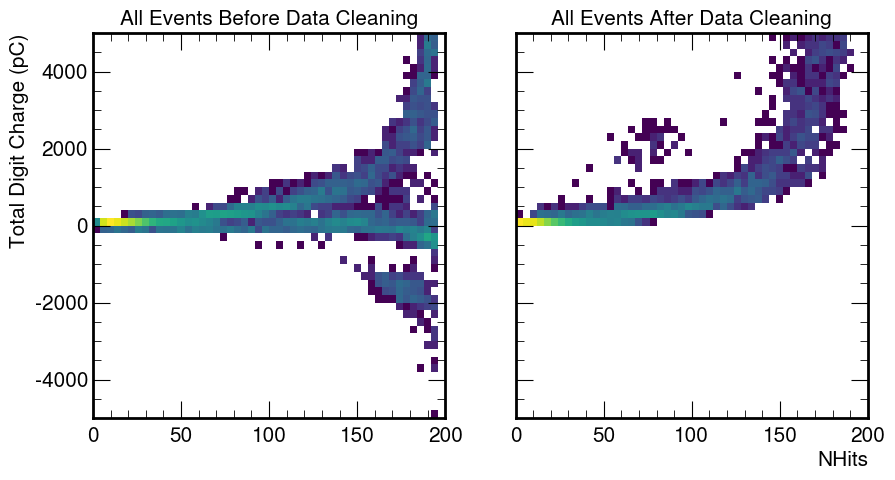

In [18]:
# Classic plot for all events

total_charge = [np.sum(event.hit_charges) for event in run.events]
nhits = [len(event.hit_charges) for event in run.events]

cleaned_total_charge = [np.sum(event.hit_charges[event.channel_mask==1]) for event in run.events]# if event.trigger_type['cleaned']==1 and event.time_since_last_prompt_trigger['cleaned']<3]
cleaned_nhits = [len(event.hit_charges[event.channel_mask==1]) for event in run.events]# if event.trigger_type['cleaned']==1 and event.time_since_last_prompt_trigger['cleaned']<3]


fontsize=15

fig,ax=plt.subplots(1,2,figsize=(10,5),sharey=True)
ax[0].hist2d(nhits,total_charge,bins=(50,50),range=((0,200),(-5000,5000)),norm='log')
ax[0].set_title(f"All Events Before Data Cleaning",fontsize=fontsize)
ax[0].set_ylabel('Total Digit Charge (pC)',fontsize=fontsize)
ax[0].tick_params(axis='both', which='major', labelsize=fontsize)  # Update tick label font size

ax[1].hist2d(cleaned_nhits,cleaned_total_charge,bins=(50,50),range=((0,200),(-5000,5000)),norm='log')
ax[1].set_title(f"All Events After Data Cleaning",fontsize=fontsize)
ax[1].set_xlabel('NHits',fontsize=fontsize)
ax[1].tick_params(axis='both', which='major', labelsize=fontsize)





In [19]:
# good_sim_total_charge = []
# good_sim_nhits = []
# for event in sim.events:
#     ids = event.hit_ids
#     total_charge = 0
#     good_ids = []
#     for i, id in enumerate(ids):
#         if event.channel_mask[i]==1:
#             if id in cleaned_run_good_hit_ids:
            
#                 good_ids.append(int(id))
#                 total_charge+= event.hit_charges[i] 
#     good_sim_total_charge.append(total_charge)
#     good_sim_nhits.append(len(good_ids))


# print(good_sim_total_charge)
# print(good_sim_nhits)

# sim_total_charge = [np.sum(event.hit_charges) for event in sim.events]
# sim_nhits = [len(event.hit_charges) for event in sim.events]


# fontsize=15

# fig,ax=plt.subplots(1,2,figsize=(10,5),sharey=True)
# ax[0].hist2d(sim_nhits,sim_total_charge,bins=(50,50),range=((0,200),(-5000,5000)),norm='log')
# ax[0].set_title(f"All Events Before Data Cleaning",fontsize=fontsize)
# ax[0].set_ylabel('Total Digit Charge (pC)',fontsize=fontsize)
# ax[0].tick_params(axis='both', which='major', labelsize=fontsize)  # Update tick label font size

# ax[1].hist2d(good_sim_nhits,good_sim_total_charge,bins=(50,50),range=((0,200),(-5000,5000)),norm='log')
# ax[1].set_title(f"All Events After Data Cleaning",fontsize=fontsize)
# ax[1].set_xlabel('NHits',fontsize=fontsize)
# ax[1].tick_params(axis='both', which='major', labelsize=fontsize)

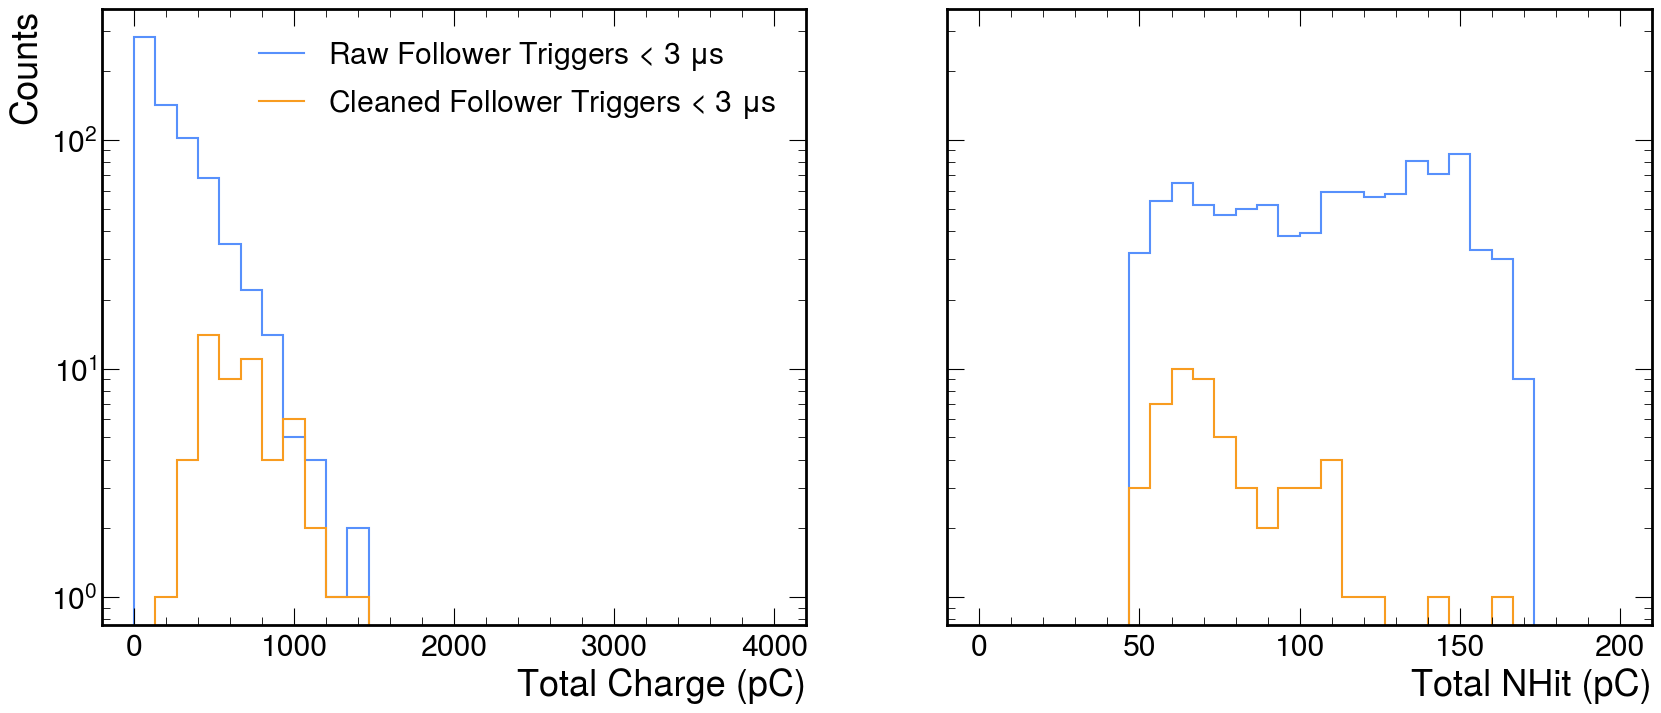

In [20]:


raw_run_follower_total_charge = [np.sum(event.hit_charges) for event in run.events if event.trigger_type['raw']==1 and event.time_since_last_prompt_trigger['raw']<3]
cleaned_run_follower_total_charge = [np.sum(event.hit_charges[event.channel_mask==1]) for event in run.events if event.trigger_type['cleaned']==1 and event.time_since_last_prompt_trigger['cleaned']<3]

raw_run_follower_nhits = [len(event.hit_charges) for event in run.events if event.trigger_type['raw']==1 and event.time_since_last_prompt_trigger['raw']<3]
cleaned_run_follower_nhits = [len(event.hit_charges[event.channel_mask==1]) for event in run.events if event.trigger_type['cleaned']==1 and event.time_since_last_prompt_trigger['cleaned']<3]


fig,ax=plt.subplots(1,2,figsize=(20,8),sharey=True)
hep.histplot(np.histogram(raw_run_follower_total_charge,bins=30,range=(0,4000)),ax=ax[0],label="Raw Follower Triggers < 3 $\mu$s")
hep.histplot(np.histogram(cleaned_run_follower_total_charge,bins=30,range=(0,4000)),ax=ax[0],label="Cleaned Follower Triggers < 3 $\mu$s")
ax[0].set_ylabel('Counts')
ax[0].set_xlabel('Total Charge (pC)')
ax[0].set_yscale('log')
ax[0].legend(loc='upper right')
hep.histplot(np.histogram(raw_run_follower_nhits,bins=30,range=(0,200)),ax=ax[1],label="Raw Follower Triggers < 3 $\mu$s")
hep.histplot(np.histogram(cleaned_run_follower_nhits,bins=30,range=(0,200)),ax=ax[1],label="Cleaned Follower Triggers < 3 $\mu$s")
ax[1].set_xlabel('Total NHit (pC)')
ax[1].set_yscale('log')





In [21]:
# fig,ax=plt.subplots(1,2,figsize=(20,8),sharey=True)
# hep.histplot(np.histogram(sim_total_charge,bins=30,range=(0,2000)),ax=ax[0],label="Raw Sim")
# hep.histplot(np.histogram(good_sim_total_charge,bins=30,range=(0,2000)),ax=ax[0],label="Cleaned Sim")
# ax[0].set_ylabel('Counts')
# ax[0].set_xlabel('Total Charge (pC)')
# ax[0].set_yscale('log')
# ax[0].legend(loc='upper right')
# hep.histplot(np.histogram(sim_nhits,bins=30,range=(0,200)),ax=ax[1],label="Raw Sim")
# hep.histplot(np.histogram(good_sim_nhits,bins=30,range=(0,200)),ax=ax[1],label="Cleaned Sim")
# ax[1].set_xlabel('Total NHit (pC)')
# ax[1].set_yscale('log')

18 groups


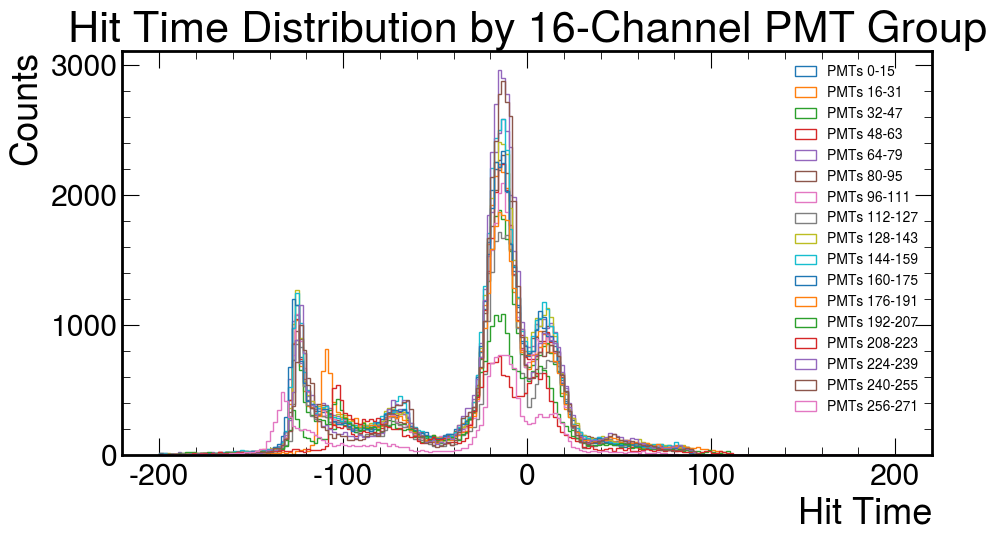

In [22]:
id2ch = dict(zip(run.pmt_id, run.pmt_ch))
ch2id = dict(zip(run.pmt_ch, run.pmt_id))

grouped_hit_times = {}

r=run
rm=run_michels

for event in r.events:
    for pmt_id, time in zip(event.hit_ids, event.hit_times):
        if True: #run.pmt_is_online[pmt_id]:#and -30<time<10:
            group = id2ch[pmt_id] // 16
            if group not in grouped_hit_times:
                grouped_hit_times[group] = []
            grouped_hit_times[group].append(time)

# Convert to NumPy array if needed
for group in grouped_hit_times:
    grouped_hit_times[group] = np.array(grouped_hit_times[group])

plt.figure(figsize=(10, 6))

colors = plt.cm.tab10.colors  # color palette
for i, (group, times) in enumerate(sorted(grouped_hit_times.items())):
    plt.hist(times, bins=200, range=(-200,200), histtype='step', label=f'PMTs {group*16}-{group*16+15}', color=colors[i % len(colors)])

plt.xlabel('Hit Time')
plt.ylabel('Counts')
plt.legend(fontsize=10)
plt.title('Hit Time Distribution by 16-Channel PMT Group')
plt.tight_layout()

print(f"{len(grouped_hit_times)+1} groups")


plt.show()

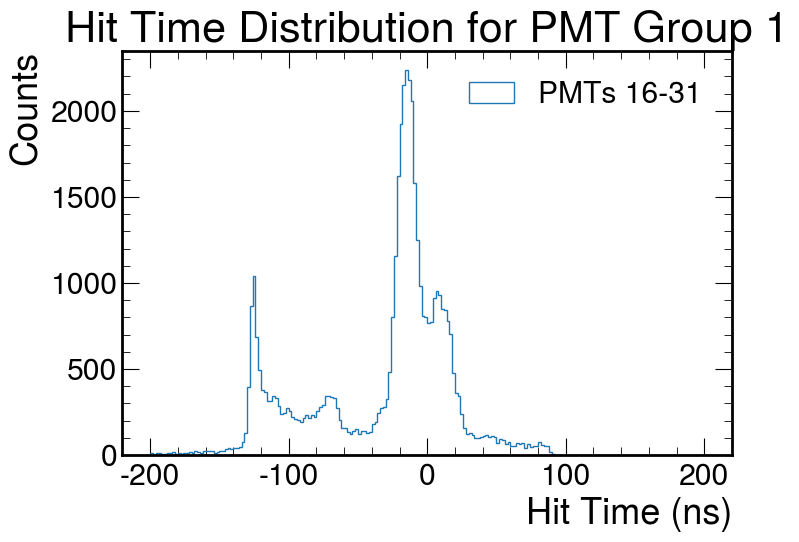

In [23]:
group_to_plot = 1 # Change this to whichever group you want

if group_to_plot in grouped_hit_times:
    plt.figure(figsize=(8, 6))
    times = grouped_hit_times[group_to_plot]
    plt.hist(times, bins=200, range=(-200, 200), histtype='step', 
             label=f'PMTs {group_to_plot*16}-{group_to_plot*16+15}',
             color='tab:blue')
    
    plt.xlabel('Hit Time (ns)')
    plt.ylabel('Counts')
    plt.title(f'Hit Time Distribution for PMT Group {group_to_plot}')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print(f"Group {group_to_plot} not found in data.")

In [24]:
channel_hit_times = {}

for event in r.events:
    for pmt_id, time in zip(event.hit_ids, event.hit_times):
        # Can do sorting here. Should really put back into class
        if True:
            channel = id2ch[pmt_id] 
            if channel not in channel_hit_times:
                channel_hit_times[channel] = []
            channel_hit_times[channel].append(time)

# Convert to NumPy array if needed
for channel in channel_hit_times:
    channel_hit_times[channel] = np.array(channel_hit_times[channel])



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


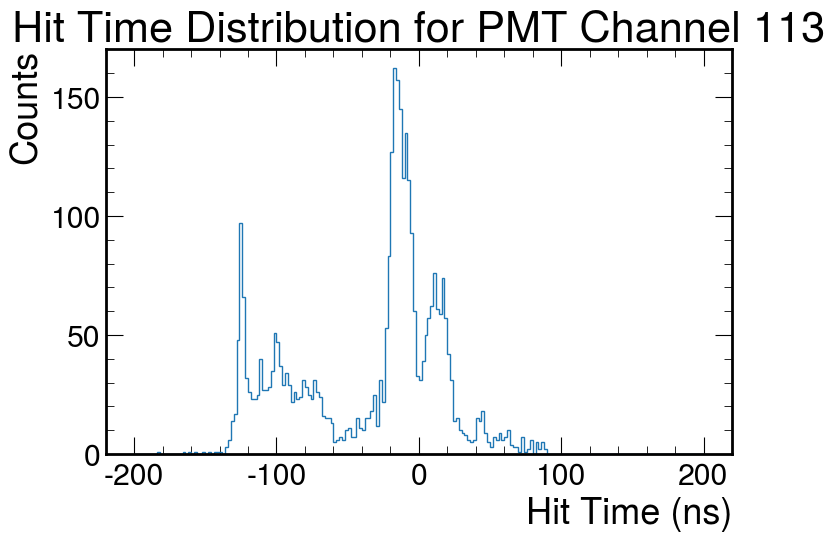

In [25]:
id2ch = dict(zip(run.pmt_id, run.pmt_ch))
ch2id = dict(zip(run.pmt_ch, run.pmt_id))

channel_to_plot =113 # Change this to whichever group you want

if channel_to_plot in channel_hit_times:
    plt.figure(figsize=(8, 6))
    times = channel_hit_times[channel_to_plot]
    plt.hist(times, bins=200, range=(-200, 200), histtype='step',
             color='tab:blue')
    
    plt.xlabel('Hit Time (ns)')
    plt.ylabel('Counts')
    plt.title(f'Hit Time Distribution for PMT Channel {channel_to_plot}')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print(f"Channel {channel_to_plot} not found in data.")
    print(f"Channel Online: {run.pmt_is_online[ch2id[channel_to_plot]]}")

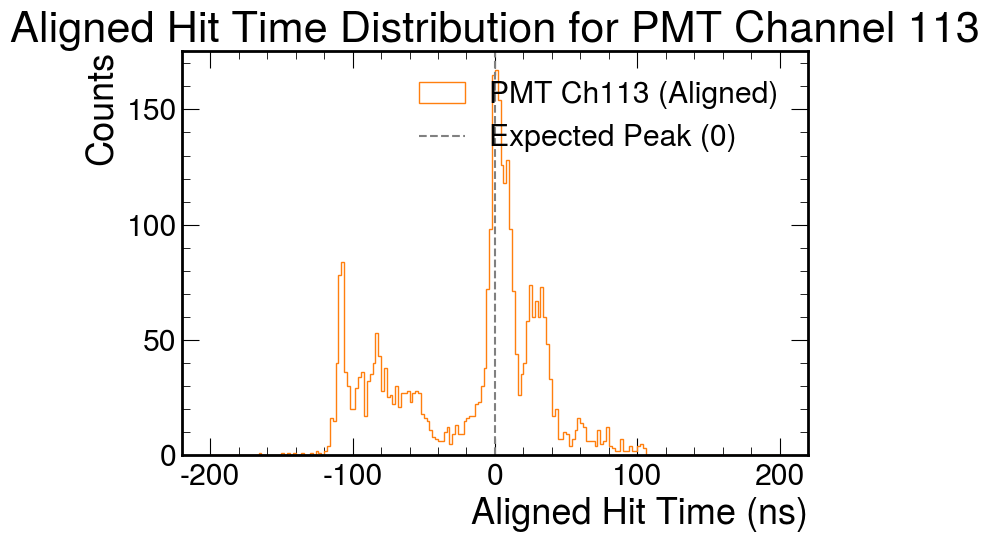

dict_keys([224, 225, 226, 227, 114, 229, 233, 116, 235, 240, 118, 241, 242, 244, 245, 120, 247, 249, 250, 258, 259, 261, 262, 265, 267, 2, 4, 5, 6, 12, 13, 14, 16, 17, 18, 19, 21, 22, 24, 27, 30, 32, 33, 34, 38, 41, 44, 46, 186, 48, 55, 56, 58, 59, 60, 61, 68, 72, 73, 74, 75, 188, 84, 86, 88, 89, 90, 92, 93, 96, 98, 102, 103, 106, 110, 130, 133, 134, 135, 136, 137, 139, 140, 141, 142, 204, 144, 147, 149, 150, 151, 152, 153, 154, 156, 157, 158, 205, 160, 161, 163, 165, 167, 168, 169, 170, 174, 206, 176, 182, 183, 193, 194, 198, 199, 203, 209, 214, 217, 219, 3, 29, 37, 42, 164, 172, 215, 112, 113, 228, 230, 231, 115, 232, 234, 117, 243, 119, 246, 121, 123, 251, 0, 1, 9, 10, 11, 25, 28, 185, 35, 43, 49, 50, 51, 52, 54, 187, 64, 65, 66, 67, 70, 71, 76, 77, 78, 80, 81, 83, 85, 87, 94, 97, 100, 101, 104, 108, 128, 129, 131, 138, 145, 146, 155, 162, 173, 177, 180, 181, 210, 216, 184, 105])


In [26]:
cable_delays = {}  # Dictionary to store delay per PMT
aligned_channel_hit_times = {}  # Store corrected hit times

def compute_cable_delays(channel_hit_times, bins=400, range=(-200, 200)):
    for pmt_ch, times in channel_hit_times.items():
        # Compute histogram
        counts, bin_edges = np.histogram(times, bins=bins, range=range)
        
        # Find the bin with the max count
        max_bin_index = np.argmax(counts)
        
        # Compute the center of that bin
        bin_center = 0.5 * (bin_edges[max_bin_index] + bin_edges[max_bin_index + 1])
        
        # Store delay
        cable_delays[pmt_ch] = bin_center
        
        # Apply delay correction to hit times
        aligned_channel_hit_times[pmt_ch] = times - bin_center

    return cable_delays

compute_cable_delays(channel_hit_times)

# Plot an aligned histogram to verify peak is at 0
def plot_aligned_channel(pmt_ch):
    if pmt_ch in aligned_channel_hit_times:
        plt.figure(figsize=(8, 6))
        times = aligned_channel_hit_times[pmt_ch]
        plt.hist(times, bins=200, range=(-200, 200), histtype='step', 
                 label=f'PMT Ch{pmt_ch} (Aligned)', color='tab:orange')
        plt.xlabel('Aligned Hit Time (ns)')
        plt.ylabel('Counts')
        plt.title(f'Aligned Hit Time Distribution for PMT Channel {pmt_ch}')
        plt.axvline(0, color='gray', linestyle='--', label='Expected Peak (0)')
        plt.legend()
        plt.tight_layout()
        # plt.yscale('log')
        plt.show()
    else:
        print(f"PMT {pmt_ch} not found in aligned data.")

# Try it
plot_aligned_channel(113)

print(cable_delays.keys())

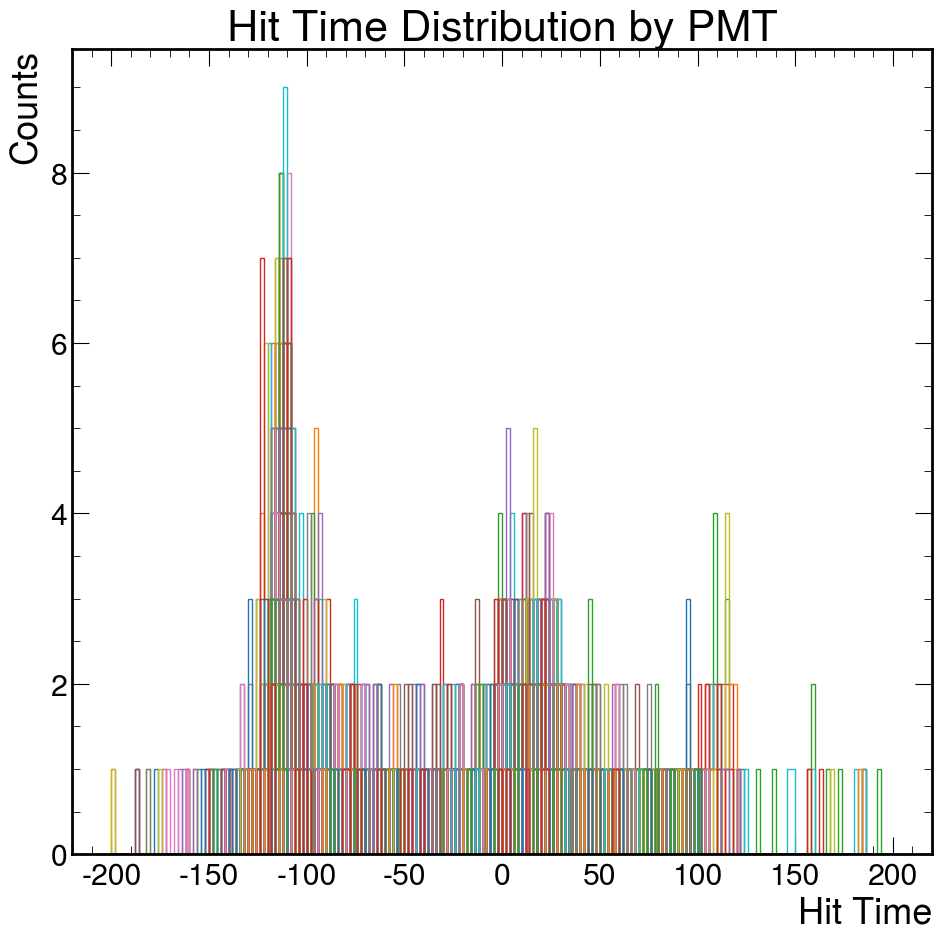

In [27]:
corrected_channel_hit_times = {}


for event in rm:
    for pmt_id, time in zip(event.hit_ids, event.hit_times):
        # Can do sorting here. Should really put back into class
        if True:#-500<event.xquad<500 and -500<event.yquad<500 and -500<event.zquad<500:
            channel = id2ch[pmt_id] 
            if channel not in corrected_channel_hit_times:
                corrected_channel_hit_times[channel] = []
            if channel not in cable_delays:
                print(f"Channel {channel} not found in cable delays")
                cable_delays[channel] = 0
            corrected_channel_hit_times[channel].append(time-cable_delays[channel])

# Convert to NumPy array if needed
for channel in corrected_channel_hit_times:
    corrected_channel_hit_times[channel] = np.array(corrected_channel_hit_times[channel])

plt.figure(figsize=(10, 10))

colors = plt.cm.tab10.colors  # color palette
for i, (channel, times) in enumerate(sorted(corrected_channel_hit_times.items())):
    plt.hist(times, bins=200, range=(-200,200), histtype='step', label=f'PMTs {channel}', color=colors[i % len(colors)])

plt.xlabel('Hit Time')
plt.ylabel('Counts')
#plt.legend()
plt.title('Hit Time Distribution by PMT')
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


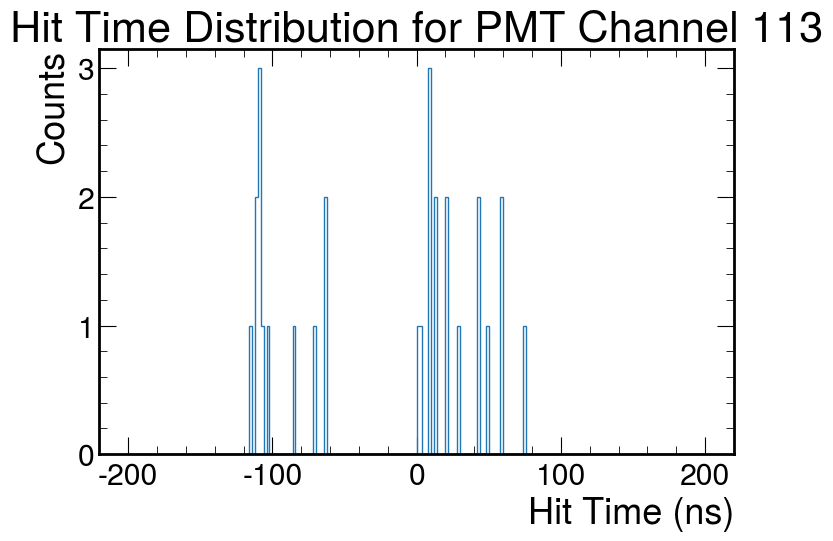

In [28]:
id2ch = dict(zip(run.pmt_id, run.pmt_ch))
ch2id = dict(zip(run.pmt_ch, run.pmt_id))

channel_to_plot =113 # Change this to whichever group you want

if channel_to_plot in corrected_channel_hit_times:
    plt.figure(figsize=(8, 6))
    times = corrected_channel_hit_times[channel_to_plot]
    plt.hist(times, bins=200, range=(-200, 200), histtype='step',
             color='tab:blue')
    
    plt.xlabel('Hit Time (ns)')
    plt.ylabel('Counts')
    plt.title(f'Hit Time Distribution for PMT Channel {channel_to_plot}')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print(f"Channel {channel_to_plot} not found in data.")
    print(f"Channel Online: {run.pmt_is_online[ch2id[channel_to_plot]]}")

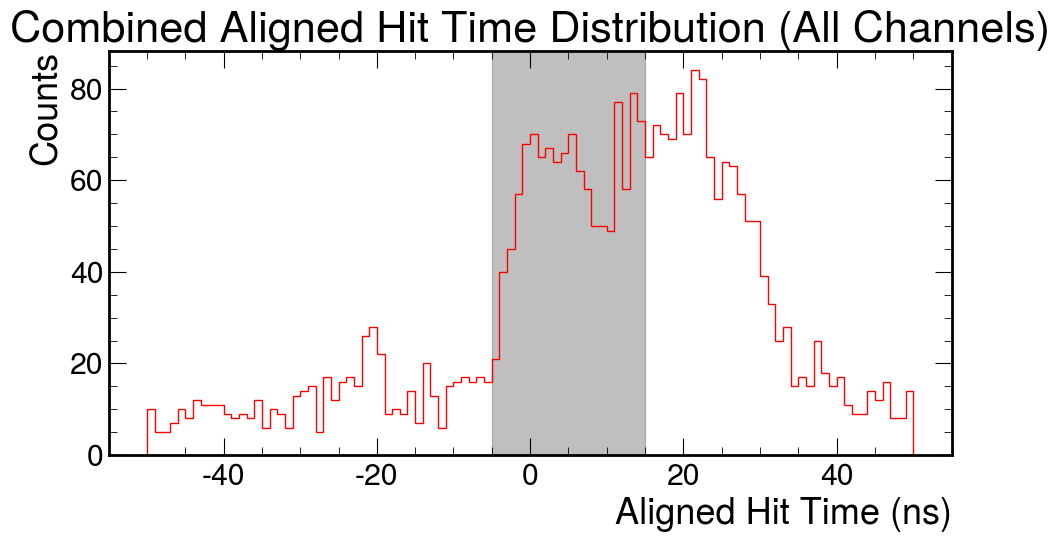

In [29]:

# Combine all aligned times into one array
all_corrected_times = np.concatenate(list(corrected_channel_hit_times.values()))

# Plot the combined histogram
plt.figure(figsize=(10, 6))
plt.hist(all_corrected_times, bins=100, range=(-50, 50), histtype='step', edgecolor='red')
plt.axvspan(-5,15,color='grey',alpha=0.5)
plt.xlabel('Aligned Hit Time (ns)')
plt.ylabel('Counts')
plt.title('Combined Aligned Hit Time Distribution (All Channels)')
plt.tight_layout()
plt.show()

In [30]:

# Define PMT channels
barrel_boards = [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11]
barrel_channels = [16 * board + i for board in barrel_boards for i in range(16)]


special_channels = np.arange(0, 36, 1)

top_boards =  [12, 13]
top_channels = [16 * board + i for board in top_boards for i in range(16)]

dichroic_boards = [7]
dichroic_channels = [16 * board + i for board in dichroic_boards for i in range(16)]

bottom_boards = [14, 15]
bottom_channels = [16 * board + i for board in bottom_boards for i in range(16)]

behind_boards = [16]
behind_channels = [16 * board + i for board in behind_boards for i in range(13)]

# Create channel to ID mapping
ch2id = dict(zip(run.pmt_ch, run.pmt_id))

# Convert channel lists to ID lists
barrel_ids = [ch2id[ch] for ch in barrel_channels if ch in ch2id]
bottom_ids = [ch2id[ch] for ch in bottom_channels if ch in ch2id]
dichroic_ids = [ch2id[ch] for ch in dichroic_channels if ch in ch2id]
special_ids = [ch2id[ch] for ch in special_channels if ch in ch2id]
top_ids = [ch2id[ch] for ch in top_channels if ch in ch2id]
behind_ids = [ch2id[ch] for ch in behind_channels if ch in ch2id]


53


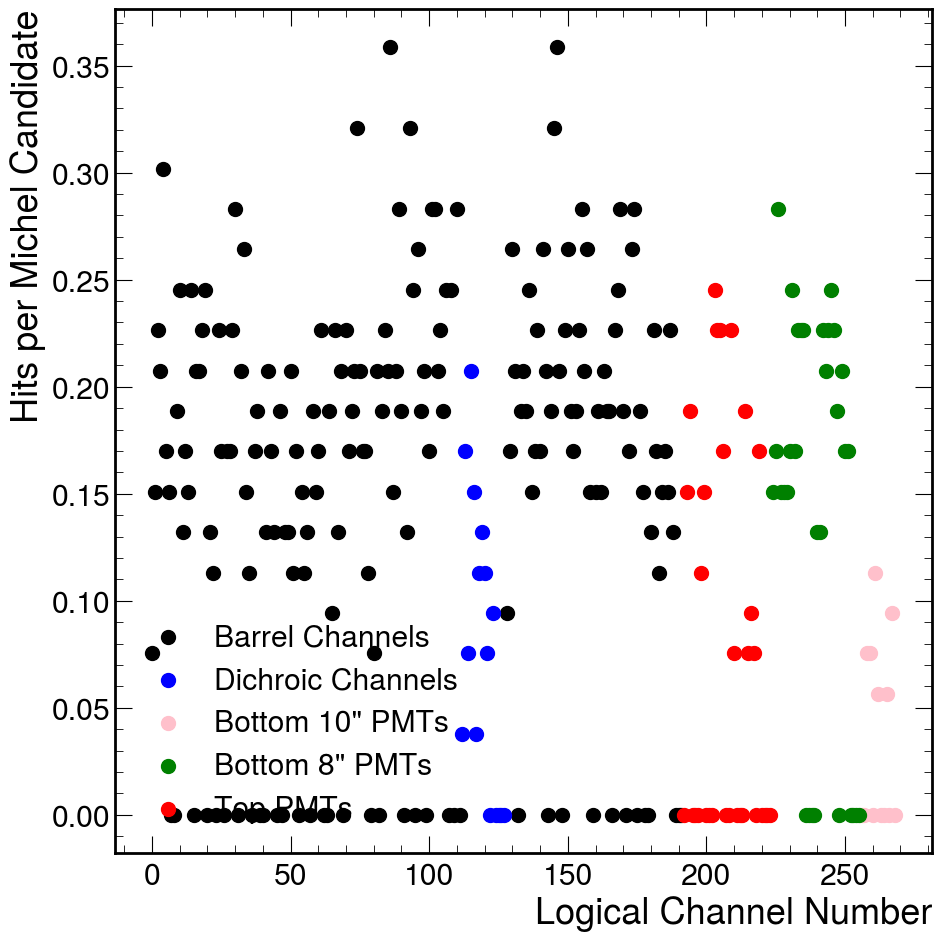

In [31]:
pmt_id_to_ch = dict(zip(run.pmt_id, run.pmt_ch))

# Assuming each PMT ID maps directly to its LCN (i.e., pmt_id == lcn)
pmt_hit_counts = np.zeros(np.max(run.pmt_ch)+1, dtype=int)

# Count hits for online PMTs
for i, (pmt_ch, times) in enumerate(sorted(corrected_channel_hit_times.items())):
    cut_times = []
    for time in times:
        if -5<time<25:
            pmt_hit_counts[pmt_ch] += 1

coinc_hit_counts = pmt_hit_counts / len(rm)


#coinc_hit_counts = coinc_hit_counts[coinc_hit_counts>0.1]
print(len(rm))

# Plot
plt.figure(figsize=(10, 10))
#plt.scatter(range(len(pmt_hit_counts)), coinc_hit_counts, s=100, alpha=0.5, color='black')

# Optional: highlight barrel and dichroic
plt.scatter(barrel_channels, coinc_hit_counts[barrel_channels], s=100, alpha=1, color='black', label='Barrel Channels')
plt.scatter(dichroic_channels, coinc_hit_counts[dichroic_channels], s=100, alpha=1, color='blue', label='Dichroic Channels')
plt.scatter(behind_channels, coinc_hit_counts[behind_channels], s=100, alpha=1, color='pink', label='Bottom 10" PMTs')
plt.scatter(bottom_channels, coinc_hit_counts[bottom_channels], s=100, alpha=1, color='green', label='Bottom 8" PMTs')
plt.scatter(top_channels, coinc_hit_counts[top_channels], s=100, alpha=1, color='red', label='Top PMTs')

plt.xlabel("Logical Channel Number")
plt.ylabel("Hits per Michel Candidate")
plt.legend(loc='lower left')
#plt.ylim(np.max(pmt_hit_counts)/2,2*np.max(pmt_hit_counts))
plt.tight_layout()


Dichroic avg: 0.000 ± 0.000 hits/event
Bottom 8" avg: 0.001 ± 0.000 hits/event
Ratio (dichroic/bottom): 0.45 ± 0.07


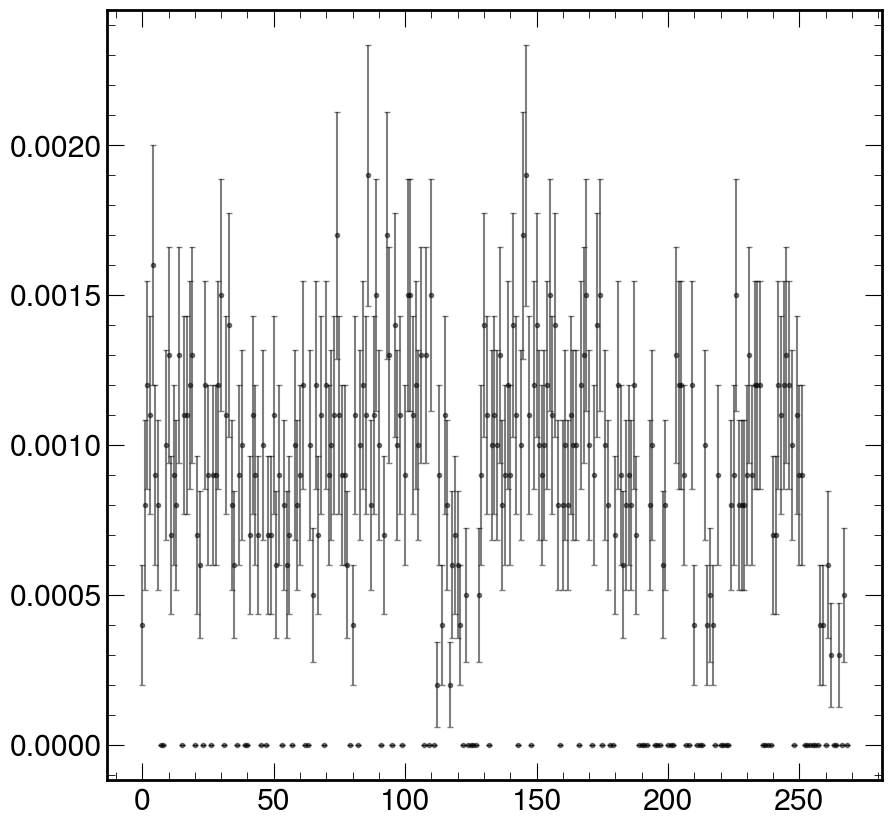

In [32]:
import numpy as np
from uncertainties import ufloat  # Requires `uncertainties` package (pip install uncertainties)

# Convert hit counts to rates and propagate Poisson errors
pmt_hit_rates = []
pmt_hit_errors = []

for count in pmt_hit_counts:
    # For each PMT: rate = count / N_events, with uncertainty √count / N_events
    N_events = len(run.events)
    rate = count / N_events
    error = np.sqrt(count) / N_events  # Poisson error propagation
    pmt_hit_rates.append(rate)
    pmt_hit_errors.append(error)

# Convert to numpy arrays
pmt_hit_rates = np.array(pmt_hit_rates)
pmt_hit_errors = np.array(pmt_hit_errors)

# Plot with error bars
plt.errorbar(
    x=np.arange(len(pmt_hit_rates)),
    y=pmt_hit_rates,
    yerr=pmt_hit_errors,
    fmt='o',
    markersize=3,
    capsize=2,
    alpha=0.5,
    color='black',
    label='PMT hit rates ± 1σ'
)

def weighted_average_with_uncertainty(rates, errors):
    """Calculate weighted average and its uncertainty."""
    weights = 1 / (errors ** 2)
    avg = np.sum(weights * rates) / np.sum(weights)
    err = 1 / np.sqrt(np.sum(weights))
    return avg, err

# Dichroic channels
dichroic_rates = pmt_hit_rates[dichroic_channels]
dichroic_errors = pmt_hit_errors[dichroic_channels]
avg_dichroic, err_dichroic = weighted_average_with_uncertainty(
    dichroic_rates[dichroic_rates > 0.0001],
    dichroic_errors[dichroic_rates > 0.0001]
)

# Bottom 8" channels
bottom_rates = pmt_hit_rates[bottom_channels]
bottom_errors = pmt_hit_errors[bottom_channels]
avg_bottom, err_bottom = weighted_average_with_uncertainty(
    bottom_rates[bottom_rates > 0.0001],
    bottom_errors[bottom_rates > 0.0001]
)

print(f"Dichroic avg: {avg_dichroic:.3f} ± {err_dichroic:.3f} hits/event")
print(f"Bottom 8\" avg: {avg_bottom:.3f} ± {err_bottom:.3f} hits/event")

R = avg_dichroic / avg_bottom
R_err = R * np.sqrt((err_dichroic/avg_dichroic)**2 + (err_bottom/avg_bottom)**2)

print(f"Ratio (dichroic/bottom): {R:.2f} ± {R_err:.2f}")


In [33]:
print(run.pmt_type)

[4 1 4 4 1 4 4 1 4 4 4 1 4 4 1 4 1 4 4 1 4 4 4 4 1 4 4 1 1 4 4 1 4 4 1 4 3
 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [34]:
test = [event for event in run.events if np.median(event.hit_times)<-100]

times = [event.hit_times for event in test]
charges = [event.hit_charges for event in test]
nhit = [len(event.hit_times) for event in test]


[-1.23804032e+02 -1.23839483e+02 -1.24623909e+02 -1.23310410e+02
 -1.25338052e+02 -1.24163810e+02 -1.23825933e+02 -1.22106076e+02
 -1.22172285e+02 -1.23534301e+02 -1.23636784e+02 -1.25158608e+02
 -1.20645453e+02 -1.20627895e+02 -1.21628483e+02 -1.23852085e+02
 -1.21106458e+02 -1.23888068e+02 -1.21218510e+02 -1.21674009e+02
 -1.22414699e+02 -1.22482237e+02 -1.25816357e+02 -1.21567712e+02
 -1.20555465e+02 -1.22723974e+02 -1.21260820e+02 -1.21758415e+02
 -1.23072042e+02 -1.22021759e+02 -1.22826097e+02 -1.20523869e+02
 -1.22969158e+02 -1.21739095e+02 -1.38771649e+02 -1.38383686e+02
 -1.38960677e+02 -1.35384386e+02 -1.18984165e+02 -1.33162921e+02
 -1.30596861e+02 -1.25698023e+02 -1.59834514e+02 -1.24967845e+02
 -1.26360600e+02 -1.26044465e+02 -1.24788875e+02 -1.24668346e+02
 -1.26643591e+02  8.30246556e+01 -1.25387178e+02 -1.25531548e+02
 -2.59596102e+00  1.79469123e+00 -1.09463381e+02 -1.24492126e+02
 -1.24997745e+02 -1.24032748e+02 -8.85484462e+01 -7.84507742e+01
 -1.25981444e+02 -1.25643

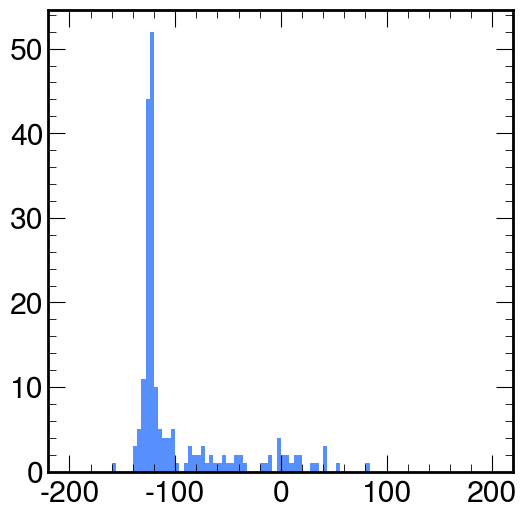

In [35]:
plt.figure(figsize=(6,6))
print(np.array(times[0]))
#plt.hist(ak.flatten(times),bins=100,range=(-200,200));
plt.hist(times[0],bins=100,range=(-200,200));

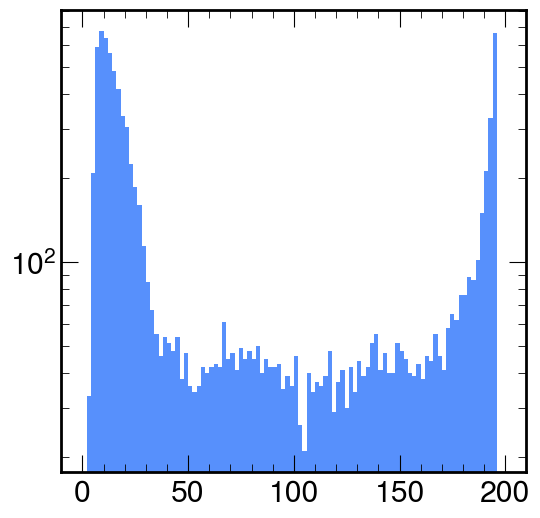

In [36]:
plt.figure(figsize=(6,6))
plt.hist(nhits,bins=100,range=(0,200))
plt.yscale('log')

In [37]:




charge = [event.total_digit_charge_pc for event in run.events]
nhit = [event.nhits for event in run.events]

prompt_charge = [event.total_digit_charge_pc for event in run.events if event.trigger_type==0]
prompt_nhit = [event.nhits for event in run.events if event.trigger_type==0]

early_follower_charge = [event.total_digit_charge_pc for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us < 4]
early_follower_nhit = [event.nhits for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us < 4]

late_follower_charge = [event.total_digit_charge_pc for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us >= 4]
late_follower_nhit = [event.nhits for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us >= 4]

x = np.linspace(0,200,100)

fig, ax = plt.subplots(1,4, figsize=(15,5))
fig.tight_layout()
hep.hist2dplot(np.histogram2d(nhits, charge, bins=(200,200), range=((0,200),(0,15000))), ax=ax[0], norm='log')
ax[0].set_title("All Triggers")
#ax[0].plot(x,line(x,0.022,108,90),'-',linewidth=2,color='red')

hep.hist2dplot(np.histogram2d(prompt_nhit, prompt_charge, bins=(200,200), range=((0,200),(0,15000))), ax=ax[1], norm='log')
ax[1].set_title("Prompt Triggers")
ax[1].set_xlabel("NHits")
ax[1].set_ylabel("Charge (pc)")

hep.hist2dplot(np.histogram2d(early_follower_nhit, early_follower_charge, bins=(200,200), range=((0,200),(0,1500))), ax=ax[2], norm='log')
ax[2].set_title("Early Follower Triggers")
ax[2].set_xlabel("NHits")   
ax[2].set_ylabel("Charge (pc)")

hep.hist2dplot(np.histogram2d(late_follower_nhit, late_follower_charge, bins=(200,200), range=((0,200),(0,1500))), ax=ax[3], norm='log')
ax[3].set_title("Late Follower Triggers")
ax[3].set_xlabel("NHits")
ax[3].set_ylabel("Charge (pc)")

# Cut on nhit and charge aboce 100 nhit to isolate the three regions
# Top is prompt muons
# Bottoms is early michels
# What is middle? Late something

AttributeError: 'Event' object has no attribute 'total_digit_charge_pc'

In [ ]:
# early_total_charge = [event.total_gaussian_charge_pc for event in run.events if event.time_since_last_trigger_us<3]
# late_total_charge = [event.total_gaussian_charge_pc for event in run.events if event.time_since_last_trigger_us>3]

# ec, eb = np.histogram(early_total_charge, bins=50, range=(0,500))
# lc, lb = np.histogram(late_total_charge, bins=50, range=(0,500))
# res = lc-ec
# centers = (eb[1:]+eb[:-1])/2

# plt.hist(early_total_charge, bins=50, range=(0,500), histtype='step', label='Early - Decaying Muon');
# plt.hist(late_total_charge, bins=50, range=(0,500), histtype='step', label='Late - Crossing Muon');
# plt.plot(centers, res, label='Difference',)
# plt.legend()
# plt.yscale('log')

In [ ]:
# for event in run.events:
#     event.print()

print(','.join(f"{bool}" for bool in run.pmt_is_online))


In [ ]:
nhits = run.get_nhits()

plt.figure(figsize=(10, 6))
hep.histplot(np.histogram(nhits, bins=200, range=(0, 200)), color='black')
plt.axvspan(prompt_nhit_range[0], prompt_nhit_range[1], color='red', alpha=0.5, label='Prompt Triggers')
plt.axvspan(follower_nhit_range[0], follower_nhit_range[1], color='blue', alpha=0.5, label='Follower Triggers')
plt.legend(loc='upper right',bbox_to_anchor=(1.45, 1),fontsize=20)
#plt.ylim(1e3,1e5)
plt.yscale('log')
plt.ylabel('Number of Events', fontsize=20)
plt.xlabel('Total NHits per Event', fontsize=20)

In [ ]:
ts_prompt = [event.timestamp_us for event in run.events if event.trigger_type==0]
ts_follower = [event.timestamp_us for event in run.events if event.trigger_type==1]
ts_bad = [event.timestamp_us for event in run.events if event.trigger_type==None]

deltat = [event.time_since_last_trigger_us for event in run.events if event.trigger_type==1]
deltat_follower = [event.time_since_last_prompt_trigger_us for event in run.events if event.trigger_type==1]
deltat_follower_early = [event.time_since_last_prompt_trigger_us for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us < 4 and event.n_negatives<10]
print(len(deltat),len(deltat_follower))

nhits_prompt = [event.nhits for event in run.events if event.trigger_type==0]
nhits_follower = [event.nhits for event in run.events if event.trigger_type==1]
nhits_bad = [event.nhits for event in run.events if event.trigger_type==None]

fig, ax = plt.subplots(1,2,figsize=(25, 10))
fig.tight_layout()
ax[0].plot(ts_prompt, nhits_prompt, 'o', markersize=5, label='prompt', color='red')
ax[0].plot(ts_follower, nhits_follower, 'o', markersize=5, label='follower', color='blue')
ax[0].plot(ts_bad, nhits_bad, 'o', markersize=5, label='follower', color='black')
ax[0].set_xlabel('Timestamp (µs)', loc='center',fontsize=30)
ax[0].set_ylabel('Total NHits per Event', fontsize=30)
ax[0].set_xlim(0, 5e7)
ax[0].legend(loc='upper left',bbox_to_anchor=(-0.35, 1),fontsize=25)
#ax[1].plot(deltat_follower, nhits_follower, 'o', markersize=5, label='follower', color='blue')
hd = ax[1].hist2d(deltat_follower, nhits_follower, bins=(30, 30), range=((1, 20), (0,200)),norm='log', cmap='Blues')
ax[1].set_xlabel('Time Since Last Prompt Trigger (µs)', loc='center', fontsize=30)
ax[1].set_xlim(1,20)
#ax[1].set_ylim(follower_nhit_range[0], follower_nhit_range[1])  
fig.colorbar(hd[3],ax=ax[1])
#ax[2].plot(deltat, nhits_follower, 'o', markersize=5, label='follower', color='blue')
# hdf = ax[2].hist2d(deltat, nhits_follower, bins=(19, 20), range=((1, 20), (0, 200)), cmap='Blues')
# ax[2].set_xlabel('Time since last trigger (us)', fontsize=20)
# ax[2].set_xlim(1,20)
# fig.colorbar(hdf[3],ax=ax[2])

In [ ]:
plt.figure(figsize=(6, 4))
plt.hist(deltat, bins=40, range=(1, 20), histtype='step', label='Follower')
plt.hist(deltat_follower, bins=40, range=(1, 20), histtype='step', label='Follower');
plt.hist(deltat_follower_early, bins=40, range=(1,20),alpha=0.2)

In [ ]:
total_digit_charge_pc = [event.total_digit_charge_pc for event in run.events if event.trigger_type!=None] 
total_log_charge_pc = [event.total_log_charge_pc for event in run.events if event.trigger_type!=None]
total_gaussian_charge_pc = [event.total_gaussian_charge_pc for event in run.events if event.trigger_type!=None]

print(len(total_log_charge_pc),len(total_digit_charge_pc), len(total_gaussian_charge_pc))
print(total_digit_charge_pc[0])
print(total_log_charge_pc[0])
print(total_digit_charge_pc[0])

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(30, 10),sharey=True,tight_layout=True)
fontsize = 25
bins=50
upper_charge=1500
nneg=10
#log_bins = np.logspace(np.log10(1),np.log10(upper_charge), bins)

total_log_charge_pc_follower_early = [event.total_log_charge_pc for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us<4 and event.n_negatives<10]
total_log_charge_pc_follower_late = [event.total_log_charge_pc for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us>4]
total_log_charge_pc_prompt = [event.total_log_charge_pc for event in run.events if event.trigger_type==0]

ax[0].hist(total_log_charge_pc_follower_early, bins=bins, range=(0,600), histtype='step', label='Early Follower Triggers ($\Delta$T < 4 µs)');
#ax[0].hist(total_log_charge_pc_follower_late, bins=bins, range=(0,upper_charge), histtype='step', label='Late Follower Triggers ($\Delta$T > 4 µs)');
#ax[0].hist(total_log_charge_pc_prompt, bins=bins, range=(0,upper_charge), histtype='step', label='All Prompt Triggers');
ax[0].set_xlabel('Total Log Charge (pc)', fontsize=fontsize)
ax[0].set_ylabel('Triggers per bin', fontsize=fontsize)
#ax[0].set_xscale('log')
#ax[0].set_yscale('log')
#ax[0].set_xlim(3e1,1e4)
# ax[0].set_ylim(0,50)
#ax[0].legend()

total_gaussian_charge_pc_follower_early = [event.total_gaussian_charge_pc for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us<4 and event.n_negatives<10]
total_gaussian_charge_pc_follower_late = [event.total_gaussian_charge_pc for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us>4]
total_gaussian_charge_pc_prompt = [event.total_gaussian_charge_pc for event in run.events if event.trigger_type==0]

ax[1].hist(total_gaussian_charge_pc_follower_early, bins=bins, range=(0,600), histtype='step', label='Early Follower Triggers ($\Delta$T < 4 µs)');
#ax[1].hist(total_gaussian_charge_pc_follower_late, bins=bins, range=(0,upper_charge), histtype='step', label='Late Follower Triggers ($\Delta$T > 4 µs)');
#ax[1].hist(total_gaussian_charge_pc_prompt, bins=bins, range=(0,upper_charge), histtype='step', label='All Prompt Triggers');
ax[1].set_xlabel('Total Gaussian Charge (pc)', fontsize=fontsize)
ax[1].set_ylabel('Triggers per bin', fontsize=fontsize)
#ax[1].set_xscale('log')
#ax[1].set_yscale('log')
#ax[1].set_xlim(3e1,1e4)
# ax[1].set_ylim(0,50)
#ax[1].legend()

total_digit_charge_pc_follower_early = [event.total_digit_charge_pc for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us<4 and event.n_negatives<10]
total_digit_charge_pc_follower_late = [event.total_digit_charge_pc for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us>4]
total_digit_charge_pc_prompt = [event.total_digit_charge_pc for event in run.events if event.trigger_type==0]

ax[2].hist(total_digit_charge_pc_follower_early, bins=bins, histtype='step', label='Early Follower Triggers ($\Delta$T < 4 µs)');
#ax[2].hist(total_digit_charge_pc_follower_late, bins=bins, range=(0,upper_charge), histtype='step', label='Late Follower Triggers ($\Delta$T > 4 µs)');
#ax[2].hist(total_digit_charge_pc_prompt, bins=bins, range=(0,upper_charge), histtype='step', label='All Prompt Triggers');
ax[2].set_xlabel('Total Digit Charge (pc)', fontsize=fontsize)
ax[2].set_ylabel('Triggers per bin', fontsize=fontsize)
#ax[2].set_xlim(3e1,2e4)
#ax[2].set_xscale('log')
#ax[2].set_yscale('log')
# ax[2].set_ylim(0,50)
ax[2].legend(loc='upper left')

In [ ]:
test = [event for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us<4 and event.n_negatives>10]

def plot_event_waveforms_together(event_id, events):

    vres=2000/pow(2,14)
    time=np.arange(-110,110,2)
    event = events[event_id]  # Get the event by ID
    plt.figure(figsize=(10,6))
    for waveform in event.waveforms:
        plt.plot(time,waveform*vres)
    fontsize=16
    plt.title(f"Event {event_id}", fontsize=fontsize)
    plt.xlabel("Time(ns)", fontsize=fontsize)
    plt.ylabel("Amplitude(mV)", fontsize=fontsize)
    plt.show()

# Example usage
plot_event_waveforms_together(event_id=6, events=test)

In [ ]:

for event in test:
    waveforms = event.waveforms
    charges = event.digit_charge_pc
    charge_ids = event.digit_pmt_id
    negs = event.n_negatives

    max_charge=np.max(charges)
    median_charge=np.median(charges)
    mdm=max_charge/abs(median_charge)
    std_charge=np.std(charges)
    print(f"NN:{negs} Max:{max_charge:.2f} Median:{median_charge:.2f} MdM:{mdm:.2f}")


In [ ]:
tcharges = [event.total_digit_charge_pc for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us<4]
tnegs = [event.n_negatives for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us<4]
std = [np.std(event.digit_charge_pc) for event in run. events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us<4]

plt.hist2d(tnegs,std,bins=(50,50),norm='log')


In [ ]:

digits = [event.digit_charge_pc for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us <4]

print(len(digits))
print(len(digits[3]),digits[0])
print(len(digits[2]),digits[1])

fds = digits[1]
print(fds)

import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np

# Assuming `fds` is your data
counts, bin_edges = np.histogram(fds, bins=15,range=(-5,10))

# Plot the histogram
plt.figure(figsize=(8, 8))
hep.histplot(counts, bins=bin_edges, color='blue', label='Digit Charges')
plt.xlabel('Digit Charge (pc)', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.title('Histogram of Digit Charges', fontsize=16)
plt.legend()
plt.show()
print(np.mean(fds))

In [ ]:
nhits = [event.nhits for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us < 4]
charges = [event.digit_charge_pc for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us < 4]

print(len(nhits),len(charges))

ncharges = []
for c in charges:
    ncharges.append(len(c))

plt.hist(nhits,bins=30,range=(0,150),histtype='step',label='nhits')
plt.hist(ncharges,bins=30,range=(0,150),histtype='step',label='ncharges')
plt.legend()

In [ ]:

nhit_follower_early = [event.nhits for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us<4]
nhit_follower_early_charge = [event.nhits for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us<4 and event.total_digit_charge_pc>500]
nhit_follower_late = [event.nhits for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us>4]
#nhit_follower_wierd = [event.nhits for event in run.events if event.trigger_type==1 and 8>event.time_since_last_prompt_trigger_us>3]
nhit_prompt = [event.nhits for event in run.events if event.trigger_type==0]

#plt.hist(total_log_charge_pc_follower, bins=50, range=(0,500), histtype='step', label='Follower');
plt.hist(nhit_follower_early, bins=50, range=(0,200), histtype='step', label='Early Follower Trigers ($\Delta$T < 4 µs)');
plt.hist(nhit_follower_early_charge, bins=50, range=(0,200), histtype='step', label='Early Follower Trigers ($\Delta$T < 4 µs and Charge > 500 pC');
plt.hist(nhit_follower_late, bins=50, range=(0,200), histtype='step', label='Late Follower Trigers ($\Delta$T > 4 µs)');
#plt.hist(nhit_follower_wierd, bins=50, range=(0,200), histtype='step', label='Follower Wierd');
plt.hist(nhit_prompt, bins=50, range=(0,200), histtype='step', label='All Prompt Triggers');
plt.xlabel('NHits', fontsize=20)
plt.ylabel('Counts per 4 NHit', fontsize=10)
plt.legend(loc='upper left',fontsize=14)
plt.yscale('log')

In [ ]:
# xquad = [event.xquad for event in run.events if event.xquad > -5000]
# yquad = [event.yquad for event in run.events if event.yquad > -5000]
# zquad = [event.zquad for event in run.events if event.zquad > -5000]


# fig,ax=plt.subplots(1,3,figsize=(15,5))
# ax[0].hist(xquad,bins=100)
# ax[1].hist(yquad,bins=100)
# ax[2].hist(zquad,bins=100)

In [ ]:
michels = [event for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us<4 and event.n_negatives<10]




In [ ]:



times = [event.digit_time_ns for event in run.events]
print(times[0])

plt.figure(figsize=(8, 6))


times = ak.flatten(times) 


plt.hist(times, color='black', bins=500, range=(-200,200), label='Michel Candidates')
plt.yscale('log')

In [ ]:
# Now do cuts

# Timing (cable delays???? dichroicon board  may be wack)
# I think individual channels are wack - cant just look at board
# Yep, need to do individual cable delays!!

# position (fiducial?)

# normalize relative to bottom pmts

# do as a function of reco z (need updated EosSims - finish other shit!)

# am I really simualting what I am selecting from real events????

# ****** why are boards 0-50 inverted? *****

In [ ]:

plt.figure(figsize=(8, 6))
hep.hist2dplot(np.histogram2d(nhit_follower_early, total_gaussian_charge_pc_follower_early, bins=(100, 100), range=((0, 200), (0, 1500))), cmap='Blues', norm='log')

In [ ]:
plt.figure(figsize=(8, 6))
hep.hist2dplot(np.histogram2d(nhit_follower_late, total_gaussian_charge_pc_follower_late, bins=(100, 100), range=((0, 200), (0, 1500))), cmap='Reds', norm='log')

In [ ]:
plt.figure(figsize=(8, 6))
hep.hist2dplot(np.histogram2d(nhit_prompt, total_gaussian_charge_pc_prompt, bins=(100, 100), range=((0, 200), (0, 1500))), cmap='Greens', norm='log')


In [ ]:
nhits = [event.nhits for event in run.events]
charges = [event.total_log_charge_pc for event in run.events]

charge_log_bins = np.logspace(np.log10(2),np.log10(1500), bins)
nhit_log_bins = np.logspace(np.log10(2),np.log10(200), bins)

plt.figure(figsize=(8, 6))
hep.hist2dplot(np.histogram2d(nhits, charges, bins=(200, 200), range=((0, 200), (0, 1500))), norm='log')
plt.xlabel('NHits per Trigger', fontsize=20)
plt.ylabel('Total Charge per Trigger (pc)', fontsize=20)

In [ ]:
early_follower_times = [event.time_since_last_prompt_trigger_us for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us<30]
late_follower_times = [event.time_since_last_prompt_trigger_us for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us>30]


fit_decay_hist(early_follower_times,bins=29,range=(0.5,30),tau_guess=2)
fit_decay_hist(late_follower_times,bins=30,range=(100,400),tau_guess=200)

In [ ]:
nhits = [event.nhits for event in run.events if event.trigger_type==1 and 4<event.time_since_last_prompt_trigger_us<7]
charges = [event.total_gaussian_charge_pc for event in run.events if event.trigger_type==1 and 4<event.time_since_last_prompt_trigger_us<7]
plt.figure(figsize=(6, 6))
hep.hist2dplot(np.histogram2d(nhits, charges, bins=(100, 100), range=((0, 200), (0, 800))), cmap='Blues', norm='log')
plt.title("Follower Triggers with 4 < $\Delta$T < 7 µs", fontsize=20)
plt.xlabel('NHits per Trigger', fontsize=20)
plt.ylabel('Total Charge per Trigger (pc)', fontsize=20)

In [ ]:
nhits = [event.nhits for event in run.events if event.trigger_type==1 and 100<event.time_since_last_prompt_trigger_us<400]
charges = [event.total_gaussian_charge_pc for event in run.events if event.trigger_type==1 and 100<event.time_since_last_prompt_trigger_us<400]
plt.figure(figsize=(6, 6))
hep.hist2dplot(np.histogram2d(nhits, charges, bins=(100, 100), range=((0, 200), (0, 800))), cmap='Blues', norm='log')
plt.title("Follower Triggers with 0.5 < $\Delta$T < 4 µs", fontsize=20)
plt.xlabel('NHits per Trigger', fontsize=20)
plt.ylabel('Total Charge per Trigger (pc)', fontsize=20)

In [ ]:
waveforms = [event.waveforms for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us<4 and event.total_digit_charge_pc<500]
charge = [event.total_digit_charge_pc for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us<4 and event.total_digit_charge_pc<500]
print(len(waveforms))
print(len(charges))


In [ ]:
n=400
for i in range(n):
    plt.plot(waveforms[i])

In [ ]:
wf = [event.waveforms for event in run.events if event.trigger_type==1 and event.total_digit_charge_pc>500 and event.time_since_last_prompt_trigger_us<4]
c = [event.total_digit_charge_pc for event in run.events if  event.trigger_type==1 and event.total_digit_charge_pc>500 and event.time_since_last_prompt_trigger_us<4]

print(len(wf), len(c))

In [ ]:
for i in range(16):
    plt.plot(wf[i],label=c[i])
plt.legend()